In [1]:
import numpy as np
import pandas as pd

In [2]:
# data = np.load("openl3.npy") 
# data = np.load("openl3_48k.npy")
features1 = np.load("resnet.npy") # video
features2 = np.load("yamnet.npy") # audio
# data = np.load("vgg.npy") # video
print(features1.shape, features2.shape)

(25403, 2048) (25403, 2, 1024)


In [3]:
features2 = features2.reshape(25403, 2*1024)

In [4]:
labels = pd.read_csv("all_labels.csv")
labels.head()

,Unnamed: 0,file_name,timestamp,car,truck,bicycle,motorbike,bus,total,night,snow,rain,has_annotation
0,0,street_traffic-barcelona-161-4901,0.5,1.0,0.0,0.0,0.0,1.0,2.0,1.0,0.0,0.0,1.0
1,1,street_traffic-barcelona-161-4901,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0
2,2,street_traffic-barcelona-161-4901,1.5,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0
3,3,street_traffic-barcelona-161-4901,2.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0
4,4,street_traffic-barcelona-161-4901,2.5,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0


In [5]:
filtered_features1 = []
filtered_features2 = []

filtered_labels = []

In [6]:
labels[labels["has_annotation"] == 1].shape

(6346, 13)

In [7]:
for idx, row in labels.iterrows():
    if row["has_annotation"] == 1:
        filtered_features1.append(features1[idx])
        filtered_features2.append(features2[idx])
        filtered_labels.append(row)
filtered_labels = pd.DataFrame(filtered_labels).reset_index()
filtered_features1 = np.array(filtered_features1)
filtered_features2 = np.array(filtered_features2)

In [8]:
#video after PCA
from sklearn.decomposition import PCA
from sklearn import preprocessing

scaler1 = preprocessing.StandardScaler().fit(filtered_features1)
dataS1=scaler1.transform(filtered_features1)

pca1=PCA(n_components=128)
dataP1=pca1.fit_transform(dataS1)

In [9]:
#audio after PCA
scaler2 = preprocessing.StandardScaler().fit(filtered_features2)
dataS2=scaler2.transform(filtered_features2)

pca2 = PCA(n_components=128)
dataP2=pca2.fit_transform(dataS2)

In [10]:
print(dataP1.shape)
print(dataP2.shape)

(6346, 128)
(6346, 128)


In [11]:
filtered_labels.shape

(6346, 14)

In [12]:
def get_count_label(num):
    if num == 0:
        return "free"
    if num < 3:
        return "few"
    if num < 6:
        return "medium"
    return "busy"

In [13]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

labelencoder = LabelEncoder()
filtered_labels["total_encoder"] = labelencoder.fit_transform(filtered_labels["total"].apply(get_count_label))

enc = OneHotEncoder(handle_unknown='ignore')
y = enc.fit_transform(filtered_labels[["total_encoder"]]).toarray()

y

array([[0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       ...,
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.]])

In [14]:
labelencoder.classes_

array(['busy', 'few', 'free', 'medium'], dtype=object)

# concatenate audio with different amount of video

In [25]:
#split the video data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(dataP1, filtered_labels["total_encoder"], test_size=0.2, random_state=42)

In [26]:
X_train.shape

(5076, 128)

In [20]:
def evaluate_svm(model, test_features, test_labels, labels):
    accuracy = model.score(test_features, test_labels)
    print("accuracy:", accuracy)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
    disp = plot_confusion_matrix(model, test_features, test_labels,
                             display_labels=labelencoder.classes_,
                             cmap=plt.cm.Blues,
                             normalize="true", ax=ax1)

    print(disp.confusion_matrix)
    
    y_score = model.decision_function(test_features)
    

    # For each class
    precision = dict()
    recall = dict()
    average_precision = dict()
    for i in range(len(labels)):
        precision[i], recall[i], _ = precision_recall_curve(test_labels.apply(lambda x: 1 if x==i else 0),
                                                            y_score[:, i])
        average_precision[i] = average_precision_score(test_labels.apply(lambda x: 1 if x==i else 0),
                                                            y_score[:, i])
    
    colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue'])

    lines = []
    classes = []
    
    for i, color in zip(range(len(labels)), colors):
        l, = plt.plot(recall[i], precision[i], color=color, lw=2)
        lines.append(l)
        classes.append('Precision-recall for class {0} (area = {1:0.2f})'
                      ''.format(labels[i], average_precision[i]))
        

    ax2.set_xlim([0.0, 1.0])
    ax2.set_ylim([0.0, 1.05])
    ax2.set_xlabel('Recall')
    ax2.set_ylabel('Precision')
    ax2.set_title('Extension of Precision-Recall curve to multi-class')
    ax2.legend(lines, classes, loc=(0, -.38), prop=dict(size=14))
    
    plt.show()
    
    print(classification_report(test_labels, model.predict(test_features)))

    return accuracy

training samples from video:  0
accuracy: 0.24488188976377953
[[0.34131737 0.33532934 0.14371257 0.17964072]
 [0.25800377 0.33333333 0.23163842 0.17702448]
 [0.2543554  0.36236934 0.17770035 0.20557491]
 [0.30877193 0.38245614 0.21754386 0.09122807]]


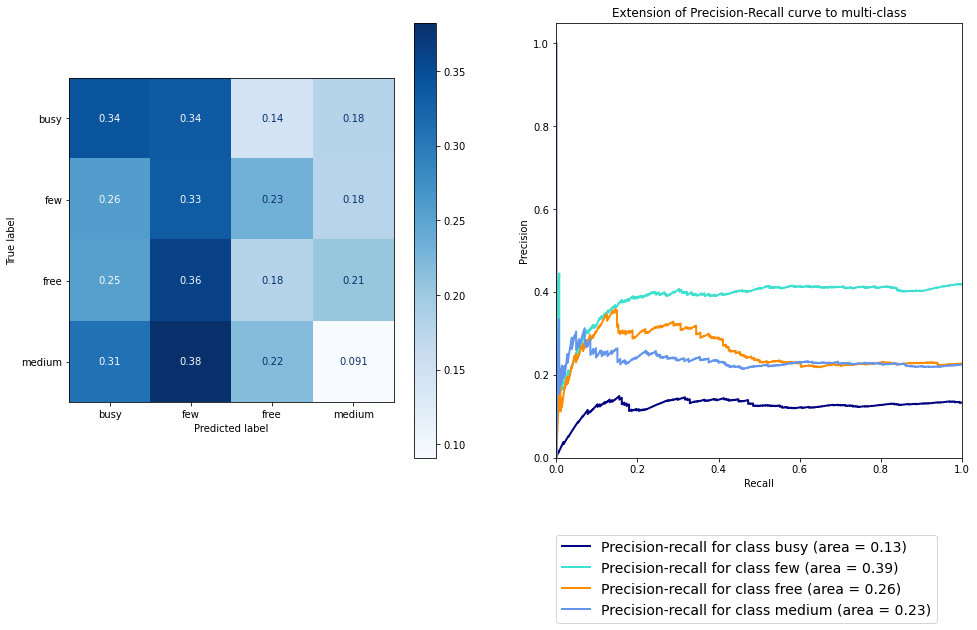

              precision    recall  f1-score   support

           0       0.16      0.34      0.22       167
           1       0.40      0.33      0.36       531
           2       0.20      0.18      0.19       287
           3       0.12      0.09      0.11       285

    accuracy                           0.24      1270
   macro avg       0.22      0.24      0.22      1270
weighted avg       0.26      0.24      0.25      1270

training samples from video:  100
accuracy: 0.30866141732283464
[[0.31736527 0.50898204 0.1497006  0.0239521 ]
 [0.16760829 0.43502825 0.29378531 0.10357815]
 [0.2543554  0.32055749 0.26829268 0.15679443]
 [0.18245614 0.52982456 0.17894737 0.10877193]]


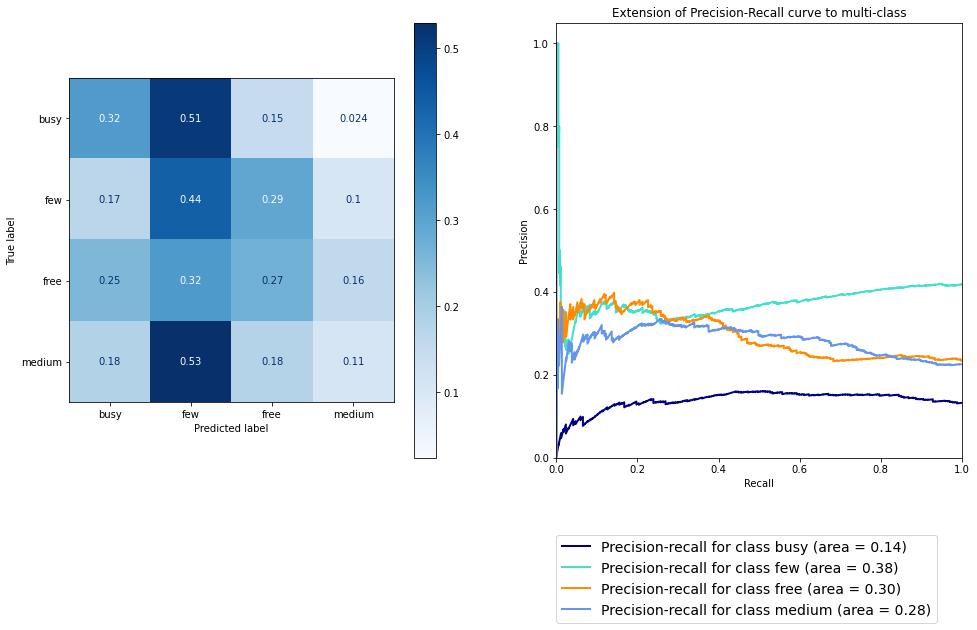

              precision    recall  f1-score   support

           0       0.20      0.32      0.24       167
           1       0.41      0.44      0.42       531
           2       0.25      0.27      0.26       287
           3       0.23      0.11      0.15       285

    accuracy                           0.31      1270
   macro avg       0.27      0.28      0.27      1270
weighted avg       0.31      0.31      0.30      1270

training samples from video:  200
accuracy: 0.3535433070866142
[[0.34730539 0.48502994 0.16167665 0.00598802]
 [0.12052731 0.50282486 0.31073446 0.06591337]
 [0.13937282 0.47038328 0.30313589 0.08710801]
 [0.12280702 0.52982456 0.21754386 0.12982456]]


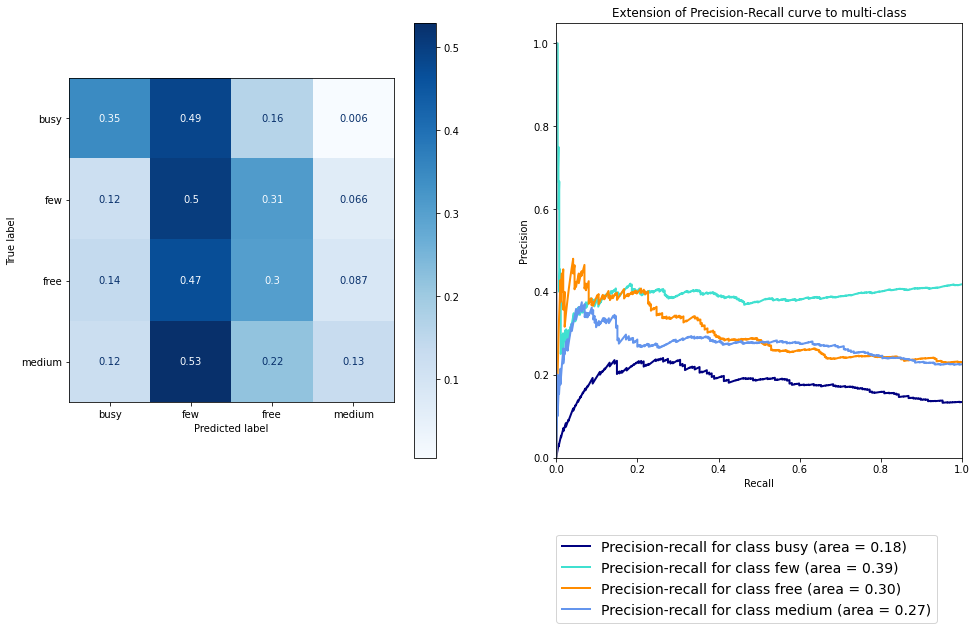

              precision    recall  f1-score   support

           0       0.29      0.35      0.32       167
           1       0.42      0.50      0.46       531
           2       0.26      0.30      0.28       287
           3       0.38      0.13      0.19       285

    accuracy                           0.35      1270
   macro avg       0.34      0.32      0.31      1270
weighted avg       0.36      0.35      0.34      1270

training samples from video:  500
accuracy: 0.41023622047244096
[[0.41317365 0.49700599 0.08982036 0.        ]
 [0.07909605 0.61770245 0.25988701 0.0433145 ]
 [0.05574913 0.55400697 0.32404181 0.06620209]
 [0.12280702 0.60701754 0.16140351 0.10877193]]


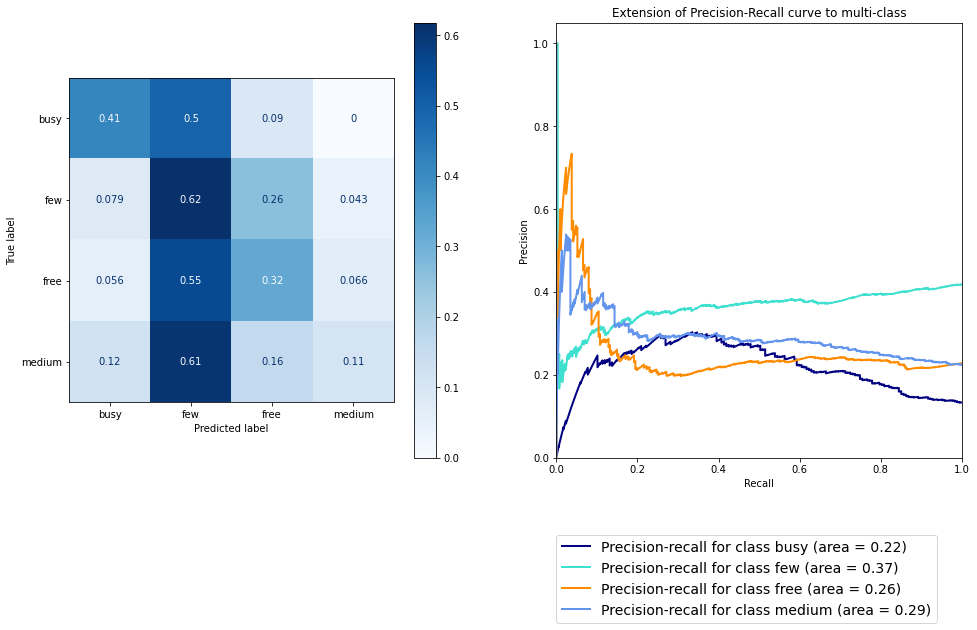

              precision    recall  f1-score   support

           0       0.43      0.41      0.42       167
           1       0.44      0.62      0.51       531
           2       0.32      0.32      0.32       287
           3       0.42      0.11      0.17       285

    accuracy                           0.41      1270
   macro avg       0.40      0.37      0.36      1270
weighted avg       0.41      0.41      0.38      1270

training samples from video:  1000
accuracy: 0.4519685039370079
[[0.4251497  0.50898204 0.06586826 0.        ]
 [0.06779661 0.68173258 0.22222222 0.02824859]
 [0.04181185 0.57142857 0.36933798 0.0174216 ]
 [0.10175439 0.63859649 0.13684211 0.12280702]]


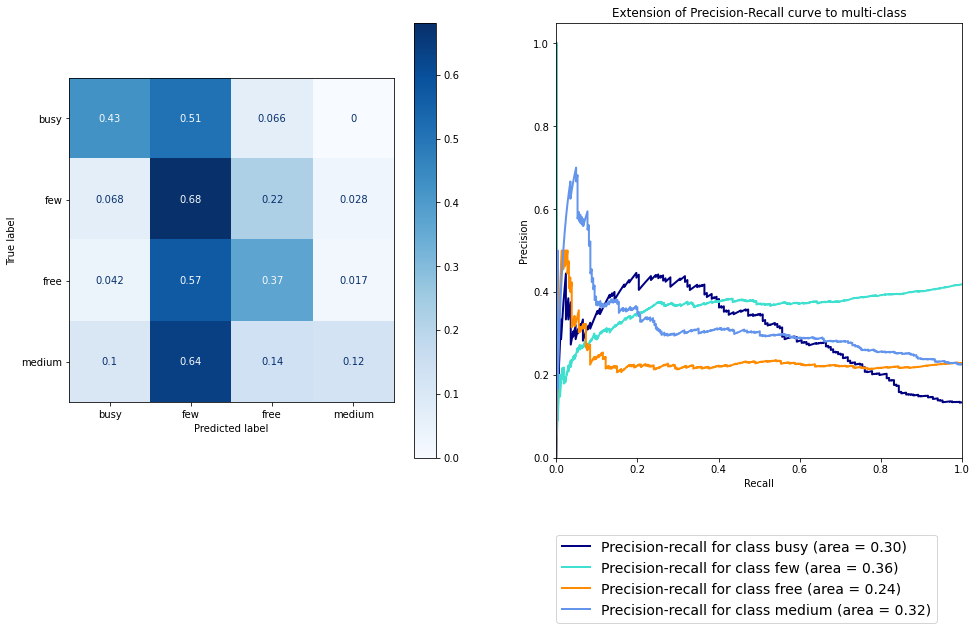

              precision    recall  f1-score   support

           0       0.48      0.43      0.45       167
           1       0.46      0.68      0.55       531
           2       0.39      0.37      0.38       287
           3       0.64      0.12      0.21       285

    accuracy                           0.45      1270
   macro avg       0.49      0.40      0.40      1270
weighted avg       0.48      0.45      0.42      1270

training samples from video:  1500
accuracy: 0.46062992125984253
[[0.41916168 0.53892216 0.04191617 0.        ]
 [0.05838041 0.69868173 0.2165725  0.02636535]
 [0.03484321 0.5261324  0.3902439  0.04878049]
 [0.10526316 0.68421053 0.09824561 0.1122807 ]]


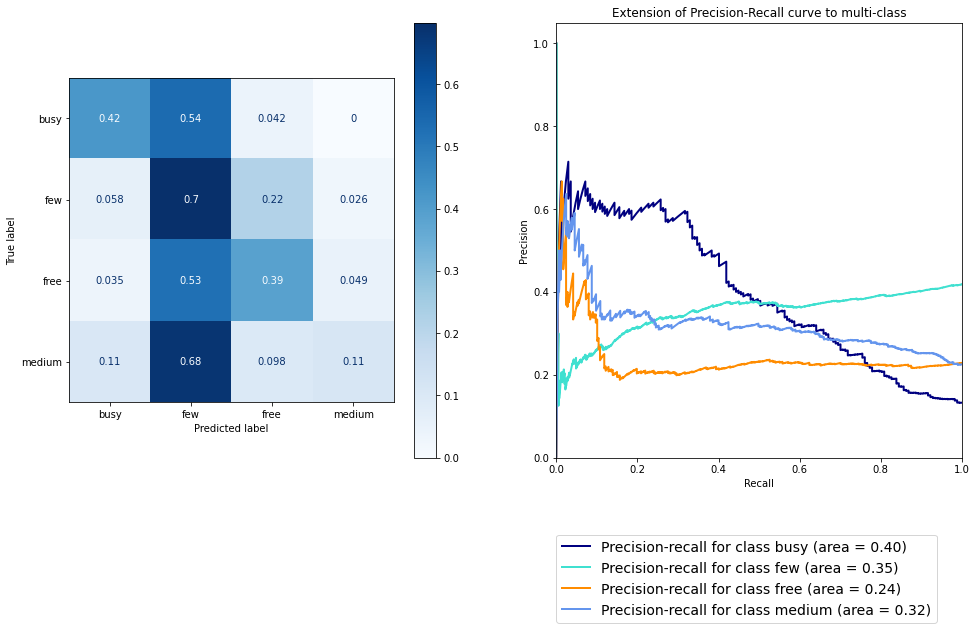

              precision    recall  f1-score   support

           0       0.50      0.42      0.45       167
           1       0.46      0.70      0.55       531
           2       0.43      0.39      0.41       287
           3       0.53      0.11      0.19       285

    accuracy                           0.46      1270
   macro avg       0.48      0.41      0.40      1270
weighted avg       0.47      0.46      0.43      1270

training samples from video:  2000
accuracy: 0.4818897637795276
[[0.4491018  0.49700599 0.05389222 0.        ]
 [0.06026365 0.69303202 0.21845574 0.02824859]
 [0.03484321 0.48432056 0.46341463 0.0174216 ]
 [0.11929825 0.66315789 0.09122807 0.12631579]]


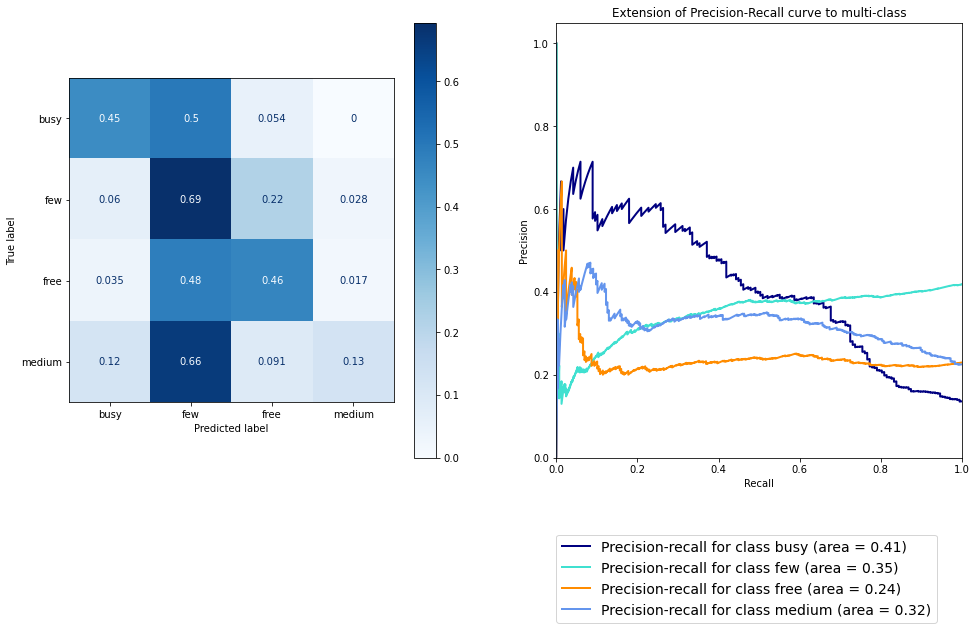

              precision    recall  f1-score   support

           0       0.50      0.45      0.47       167
           1       0.47      0.69      0.56       531
           2       0.47      0.46      0.47       287
           3       0.64      0.13      0.21       285

    accuracy                           0.48      1270
   macro avg       0.52      0.43      0.43      1270
weighted avg       0.51      0.48      0.45      1270

training samples from video:  3000
accuracy: 0.5078740157480315
[[0.4251497  0.53892216 0.03592814 0.        ]
 [0.05649718 0.69679849 0.21845574 0.02824859]
 [0.02787456 0.38675958 0.58536585 0.        ]
 [0.10526316 0.69824561 0.07017544 0.12631579]]


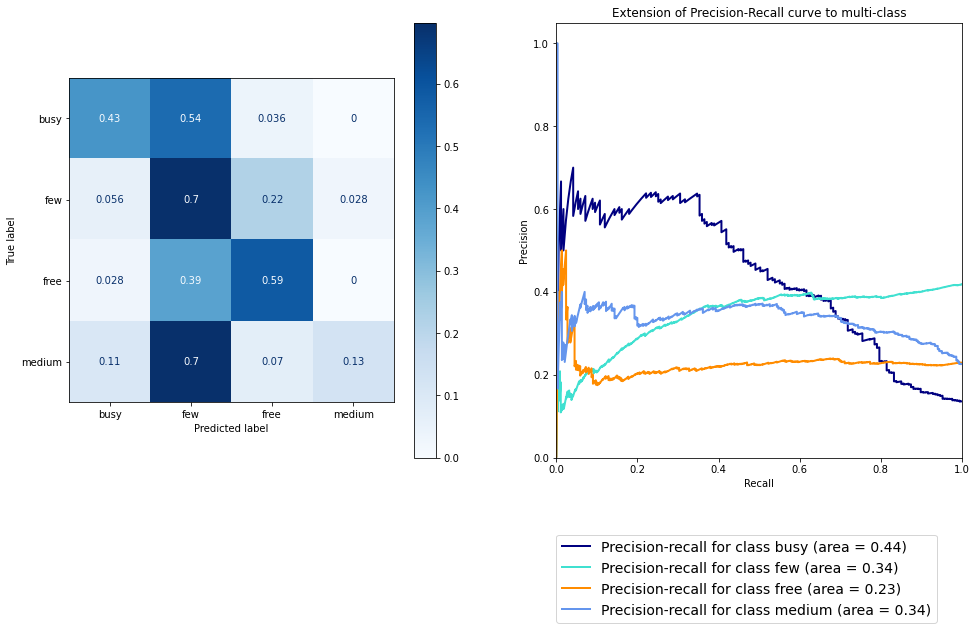

              precision    recall  f1-score   support

           0       0.51      0.43      0.46       167
           1       0.48      0.70      0.57       531
           2       0.54      0.59      0.56       287
           3       0.71      0.13      0.21       285

    accuracy                           0.51      1270
   macro avg       0.56      0.46      0.45      1270
weighted avg       0.55      0.51      0.47      1270

training samples from video:  4000
accuracy: 0.5354330708661418
[[0.44311377 0.49101796 0.04790419 0.01796407]
 [0.05084746 0.73258004 0.19774011 0.01883239]
 [0.0174216  0.3554007  0.6271777  0.        ]
 [0.1122807  0.71578947 0.04210526 0.12982456]]


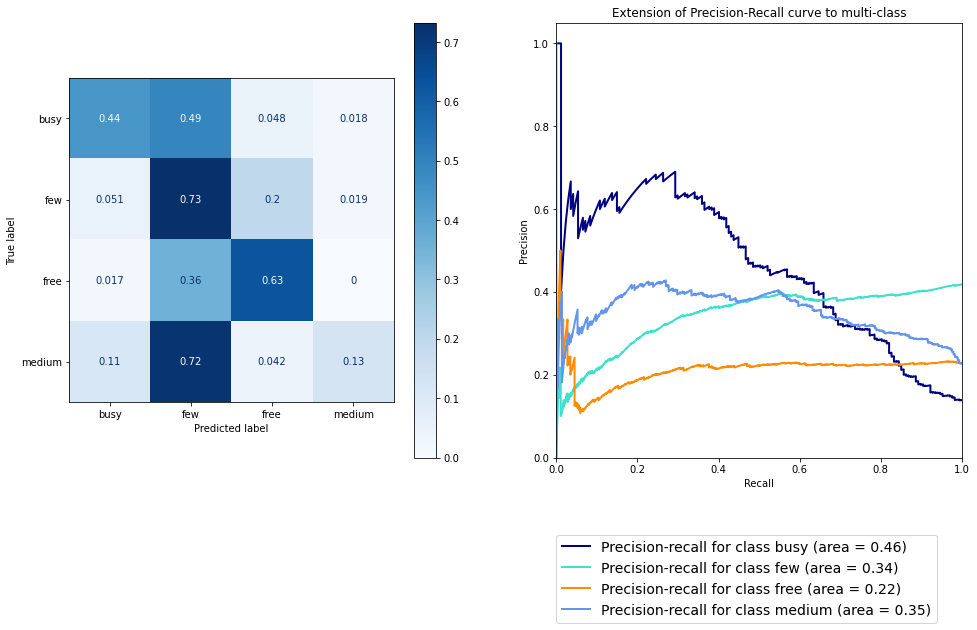

              precision    recall  f1-score   support

           0       0.54      0.44      0.49       167
           1       0.50      0.73      0.59       531
           2       0.59      0.63      0.61       287
           3       0.74      0.13      0.22       285

    accuracy                           0.54      1270
   macro avg       0.59      0.48      0.48      1270
weighted avg       0.58      0.54      0.50      1270

training samples from video:  5076
accuracy: 0.5543307086614173
[[0.43712575 0.49700599 0.02994012 0.03592814]
 [0.05084746 0.74576271 0.1826742  0.02071563]
 [0.02090592 0.35191638 0.6271777  0.        ]
 [0.10526316 0.66315789 0.03859649 0.19298246]]


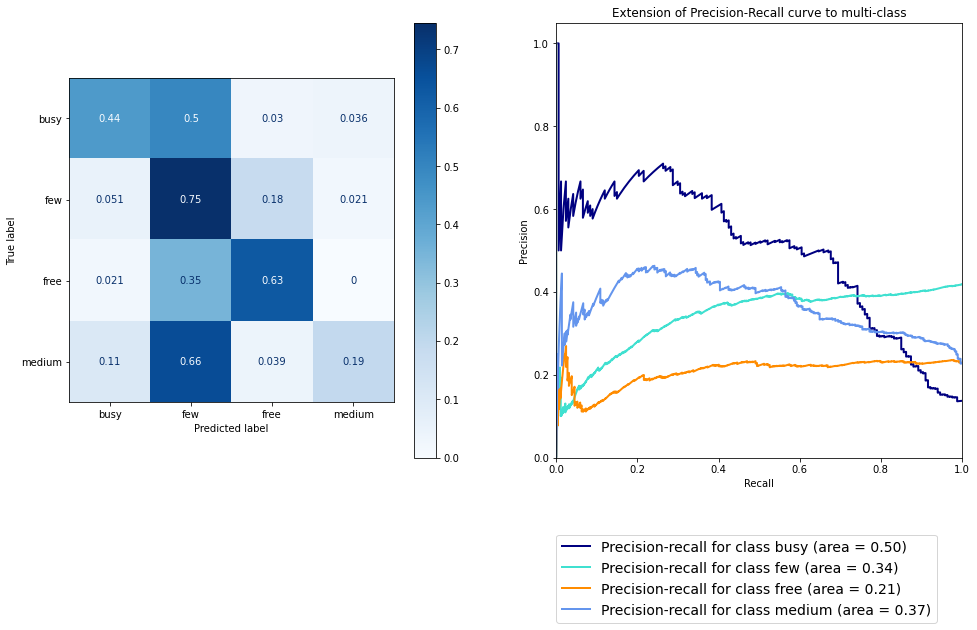

              precision    recall  f1-score   support

           0       0.54      0.44      0.48       167
           1       0.51      0.75      0.61       531
           2       0.61      0.63      0.62       287
           3       0.76      0.19      0.31       285

    accuracy                           0.55      1270
   macro avg       0.61      0.50      0.50      1270
weighted avg       0.60      0.55      0.53      1270



In [31]:
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import average_precision_score
from itertools import cycle
from sklearn.metrics import classification_report

acc = {}
numOfSamples = [0, 100, 200, 500, 1000, 1500, 2000, 3000, 4000, 5076]

for num in numOfSamples:
    print("training samples from video: ", num)
    if num > 0:
        X_combine_train = np.concatenate((X_train[:num, :], dataP2), axis=0)
        y_combine_train = np.concatenate((y_train[:num],filtered_labels["total_encoder"]), axis=0)
    else:
        X_combine_train = dataP2
        y_combine_train = filtered_labels["total_encoder"]

    clf = SVC(kernel="linear", decision_function_shape="ovo", random_state=42)
    clf.fit(X_combine_train, y_combine_train)
    random_accuracy = evaluate_svm(clf, X_test, y_test, labelencoder.classes_)
    acc[num] = random_accuracy

In [32]:
print(acc)

{0: 0.24488188976377953, 100: 0.30866141732283464, 200: 0.3535433070866142, 500: 0.41023622047244096, 1000: 0.4519685039370079, 1500: 0.46062992125984253, 2000: 0.4818897637795276, 3000: 0.5078740157480315, 4000: 0.5354330708661418, 5076: 0.5543307086614173}


In [21]:
def evaluate(model, test_features, test_labels, labels):
    accuracy = model.score(test_features, test_labels)
    print("accuracy:", accuracy)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
    disp = plot_confusion_matrix(model, test_features, test_labels,
                             display_labels=labelencoder.classes_,
                             cmap=plt.cm.Blues,
                             normalize="true", ax=ax1)

    print(disp.confusion_matrix)
    
    y_score = model.predict_proba(test_features)
    

    # For each class
    precision = dict()
    recall = dict()
    average_precision = dict()
    for i in range(len(labels)):
        precision[i], recall[i], _ = precision_recall_curve(test_labels.apply(lambda x: 1 if x==i else 0),
                                                            y_score[:, i])
        average_precision[i] = average_precision_score(test_labels.apply(lambda x: 1 if x==i else 0),
                                                            y_score[:, i])
    
    colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue'])

    lines = []
    classes = []
    
    for i, color in zip(range(len(labels)), colors):
        l, = plt.plot(recall[i], precision[i], color=color, lw=2)
        lines.append(l)
        classes.append('Precision-recall for class {0} (area = {1:0.2f})'
                      ''.format(labels[i], average_precision[i]))
        

    ax2.set_xlim([0.0, 1.0])
    ax2.set_ylim([0.0, 1.05])
    ax2.set_xlabel('Recall')
    ax2.set_ylabel('Precision')
    ax2.set_title('Extension of Precision-Recall curve to multi-class')
    ax2.legend(lines, classes, loc=(0, -.38), prop=dict(size=14))
    
    plt.show()
    
    print(classification_report(test_labels, model.predict(test_features)))
    
    return accuracy

In [24]:
#try random forest
numOfSamples = [0, 100, 200, 500, 1000, 1500, 2000, 3000, 4000, 5076]
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 20)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 100, num = 10)]
min_samples_split = [2, 5]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split}

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  7.5min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 15.4min finished


{'n_estimators': 673, 'min_samples_split': 5, 'max_features': 'sqrt', 'max_depth': 10}
accuracy: 0.28818897637795277
[[0.         0.41916168 0.58083832 0.        ]
 [0.         0.35216573 0.64783427 0.        ]
 [0.         0.37630662 0.62369338 0.        ]
 [0.         0.36491228 0.63508772 0.        ]]


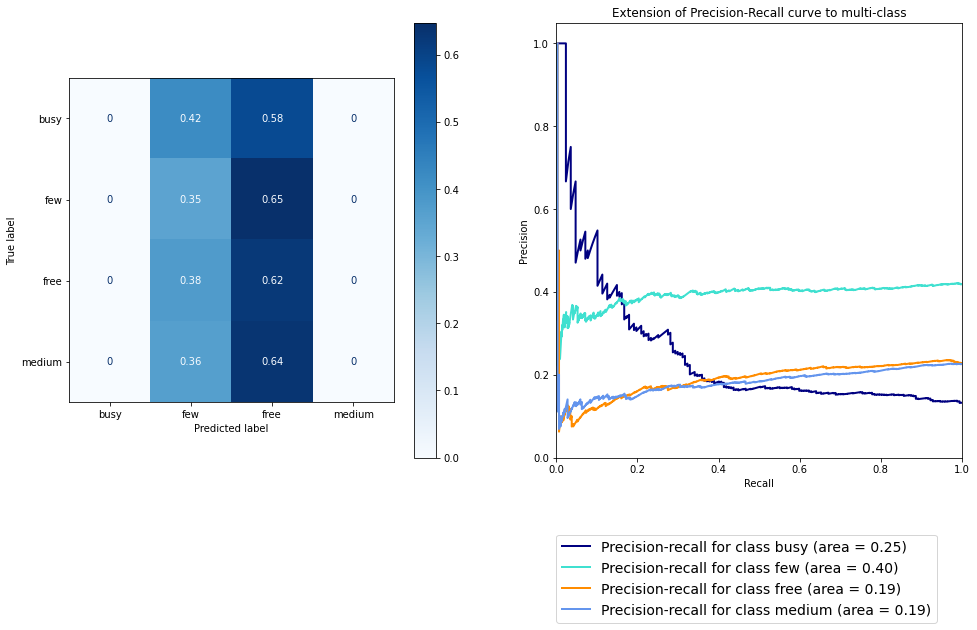

/Users/hou/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


              precision    recall  f1-score   support

           0       0.00      0.00      0.00       167
           1       0.40      0.35      0.37       531
           2       0.22      0.62      0.33       287
           3       0.00      0.00      0.00       285

    accuracy                           0.29      1270
   macro avg       0.16      0.24      0.18      1270
weighted avg       0.22      0.29      0.23      1270

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  7.9min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 16.2min finished


{'n_estimators': 863, 'min_samples_split': 2, 'max_features': 'auto', 'max_depth': 50}
accuracy: 0.37086614173228344
[[0.03592814 0.51497006 0.32934132 0.11976048]
 [0.00188324 0.48775895 0.49152542 0.01883239]
 [0.         0.36585366 0.63414634 0.        ]
 [0.00350877 0.54385965 0.36842105 0.08421053]]


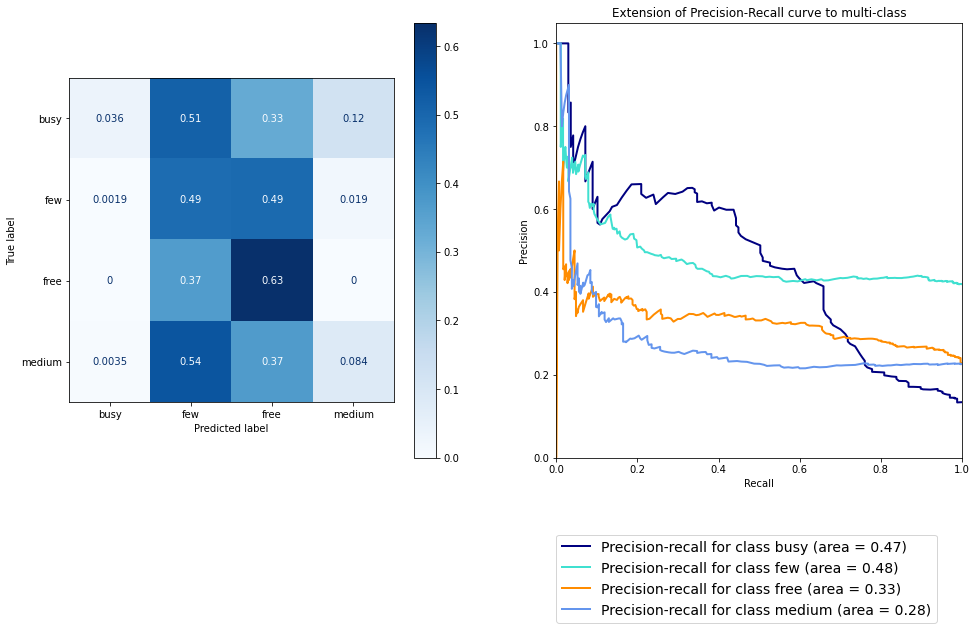

              precision    recall  f1-score   support

           0       0.75      0.04      0.07       167
           1       0.43      0.49      0.46       531
           2       0.30      0.63      0.41       287
           3       0.44      0.08      0.14       285

    accuracy                           0.37      1270
   macro avg       0.48      0.31      0.27      1270
weighted avg       0.45      0.37      0.32      1270

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  9.1min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 17.5min finished


{'n_estimators': 673, 'min_samples_split': 5, 'max_features': 'sqrt', 'max_depth': 10}
accuracy: 0.41653543307086616
[[0.05988024 0.60479042 0.25748503 0.07784431]
 [0.00188324 0.6346516  0.34463277 0.01883239]
 [0.         0.42857143 0.57142857 0.        ]
 [0.00701754 0.66666667 0.26315789 0.06315789]]


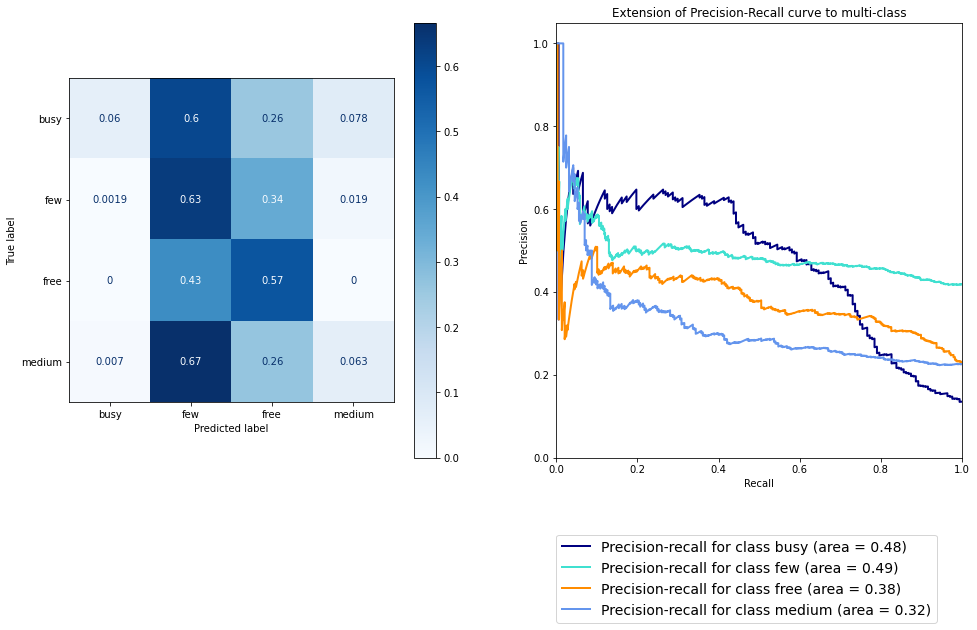

              precision    recall  f1-score   support

           0       0.77      0.06      0.11       167
           1       0.45      0.63      0.53       531
           2       0.35      0.57      0.44       287
           3       0.44      0.06      0.11       285

    accuracy                           0.42      1270
   macro avg       0.50      0.33      0.30      1270
weighted avg       0.47      0.42      0.36      1270

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  8.9min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 18.1min finished


{'n_estimators': 484, 'min_samples_split': 5, 'max_features': 'sqrt', 'max_depth': 10}
accuracy: 0.5149606299212598
[[0.04790419 0.82035928 0.02994012 0.10179641]
 [0.         0.79284369 0.1826742  0.02448211]
 [0.         0.36933798 0.63066202 0.        ]
 [0.00701754 0.78245614 0.05614035 0.15438596]]


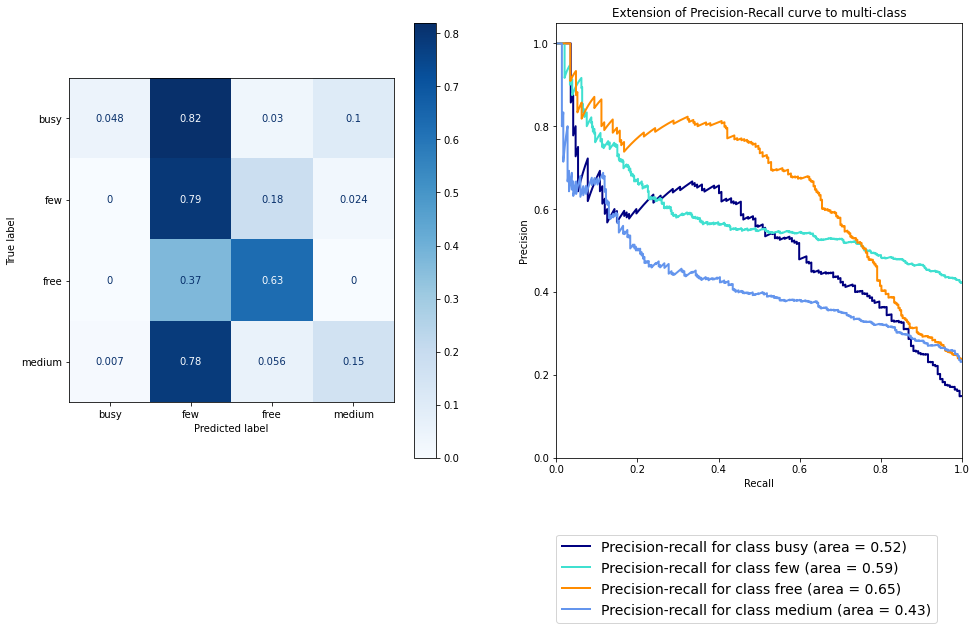

              precision    recall  f1-score   support

           0       0.80      0.05      0.09       167
           1       0.47      0.79      0.59       531
           2       0.61      0.63      0.62       287
           3       0.59      0.15      0.25       285

    accuracy                           0.51      1270
   macro avg       0.62      0.41      0.39      1270
weighted avg       0.57      0.51      0.45      1270

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 19.5min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 32.5min finished


{'n_estimators': 484, 'min_samples_split': 5, 'max_features': 'sqrt', 'max_depth': 10}
accuracy: 0.5598425196850394
[[0.25149701 0.58682635 0.01796407 0.14371257]
 [0.01318267 0.83239171 0.14124294 0.01318267]
 [0.00348432 0.36585366 0.61672474 0.01393728]
 [0.05263158 0.72982456 0.04210526 0.1754386 ]]


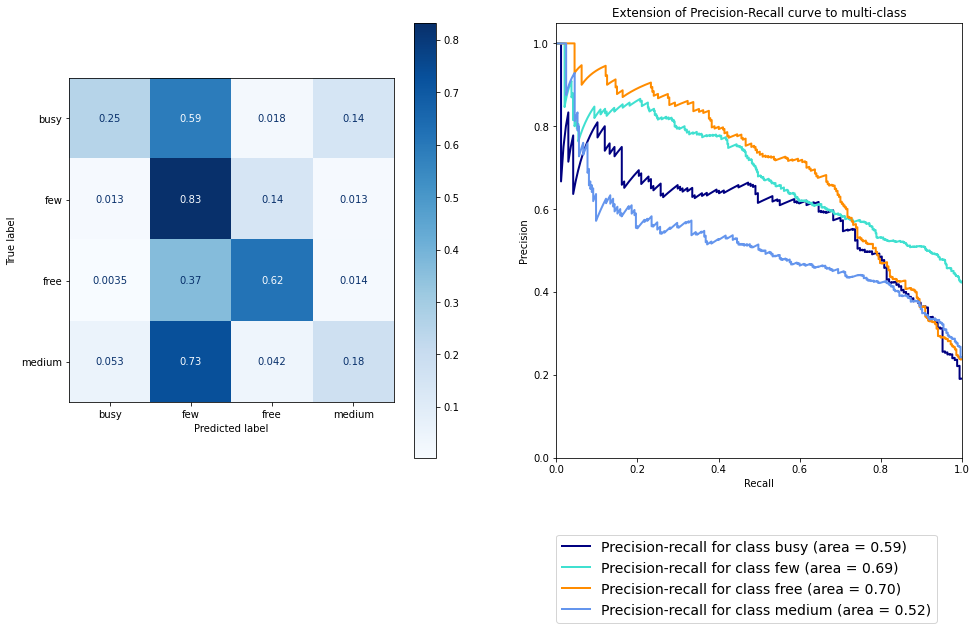

              precision    recall  f1-score   support

           0       0.65      0.25      0.36       167
           1       0.52      0.83      0.64       531
           2       0.66      0.62      0.64       287
           3       0.59      0.18      0.27       285

    accuracy                           0.56      1270
   macro avg       0.60      0.47      0.48      1270
weighted avg       0.58      0.56      0.52      1270

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 10.5min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 29.2min finished


{'n_estimators': 673, 'min_samples_split': 5, 'max_features': 'sqrt', 'max_depth': 10}
accuracy: 0.5803149606299213
[[0.32934132 0.50898204 0.01796407 0.14371257]
 [0.01883239 0.83804143 0.10546139 0.03766478]
 [0.00696864 0.3554007  0.62369338 0.01393728]
 [0.05964912 0.70877193 0.02807018 0.20350877]]


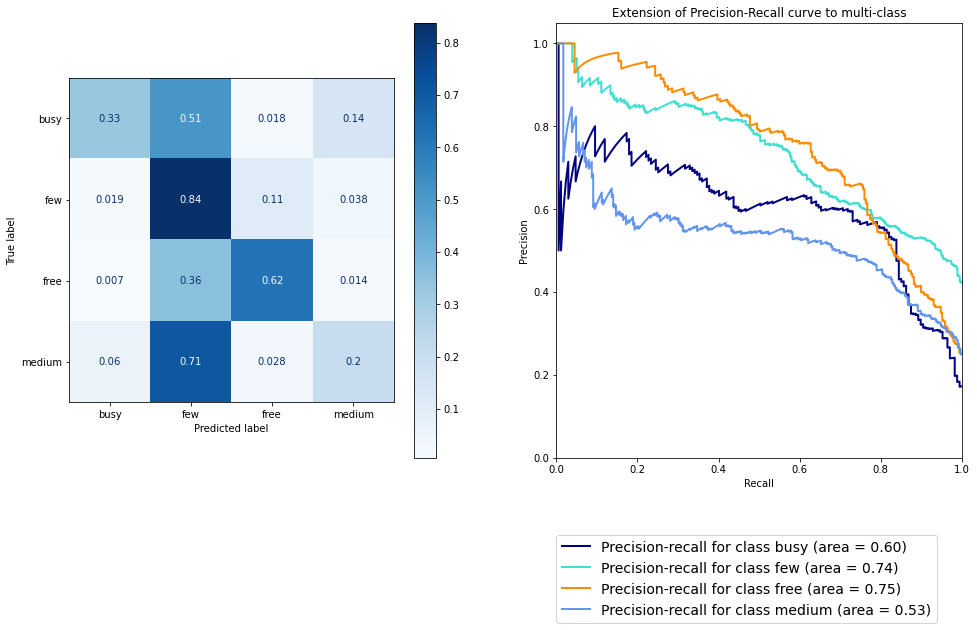

              precision    recall  f1-score   support

           0       0.65      0.33      0.44       167
           1       0.53      0.84      0.65       531
           2       0.73      0.62      0.67       287
           3       0.55      0.20      0.30       285

    accuracy                           0.58      1270
   macro avg       0.62      0.50      0.51      1270
weighted avg       0.60      0.58      0.55      1270

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 11.1min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 21.2min finished


{'n_estimators': 863, 'min_samples_split': 5, 'max_features': 'sqrt', 'max_depth': 10}
accuracy: 0.5952755905511811
[[0.37724551 0.46706587 0.01796407 0.13772455]
 [0.02259887 0.81544256 0.11864407 0.0433145 ]
 [0.01393728 0.31707317 0.65505226 0.01393728]
 [0.06315789 0.65614035 0.02807018 0.25263158]]


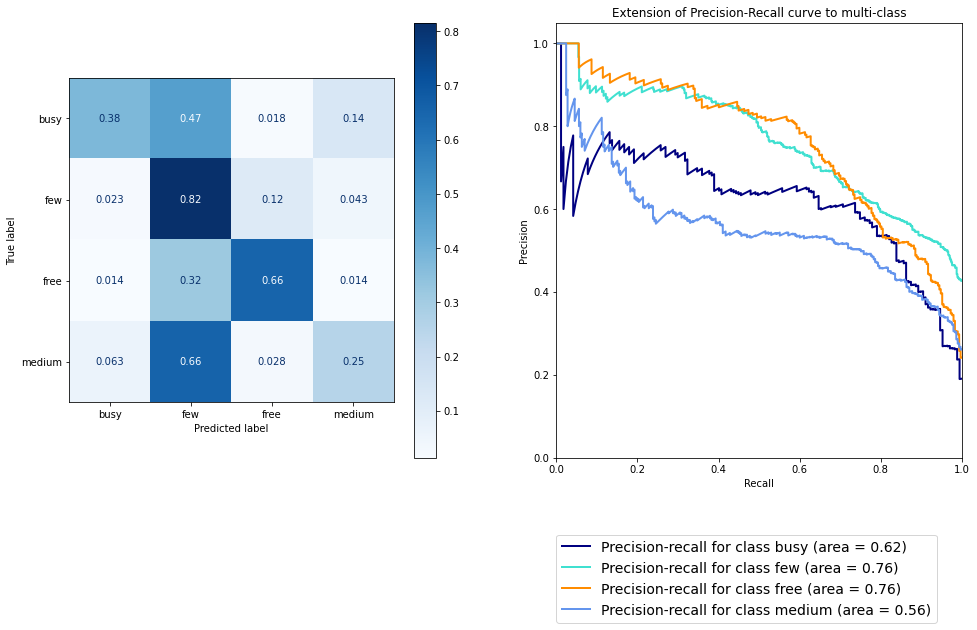

              precision    recall  f1-score   support

           0       0.65      0.38      0.48       167
           1       0.55      0.82      0.66       531
           2       0.72      0.66      0.68       287
           3       0.59      0.25      0.35       285

    accuracy                           0.60      1270
   macro avg       0.63      0.53      0.54      1270
weighted avg       0.61      0.60      0.57      1270

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 24.9min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 39.5min finished


{'n_estimators': 768, 'min_samples_split': 5, 'max_features': 'sqrt', 'max_depth': 10}
accuracy: 0.6086614173228346
[[0.4251497  0.47305389 0.01796407 0.08383234]
 [0.01694915 0.85875706 0.10546139 0.01883239]
 [0.01045296 0.33101045 0.64808362 0.01045296]
 [0.07368421 0.69122807 0.0245614  0.21052632]]


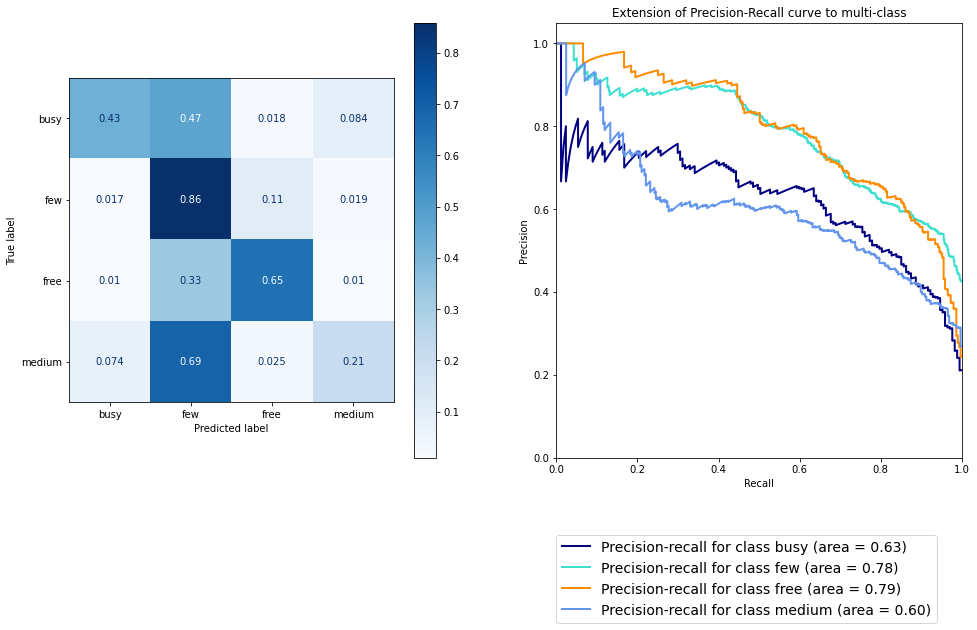

              precision    recall  f1-score   support

           0       0.68      0.43      0.52       167
           1       0.55      0.86      0.67       531
           2       0.74      0.65      0.69       287
           3       0.69      0.21      0.32       285

    accuracy                           0.61      1270
   macro avg       0.67      0.54      0.55      1270
weighted avg       0.64      0.61      0.58      1270

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 14.9min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 42.0min finished


{'n_estimators': 1147, 'min_samples_split': 2, 'max_features': 'auto', 'max_depth': 70}
accuracy: 0.7236220472440945
[[0.61077844 0.19760479 0.00598802 0.18562874]
 [0.01883239 0.83239171 0.09981168 0.04896422]
 [0.01045296 0.17421603 0.80836237 0.00696864]
 [0.0877193  0.38947368 0.02105263 0.50175439]]


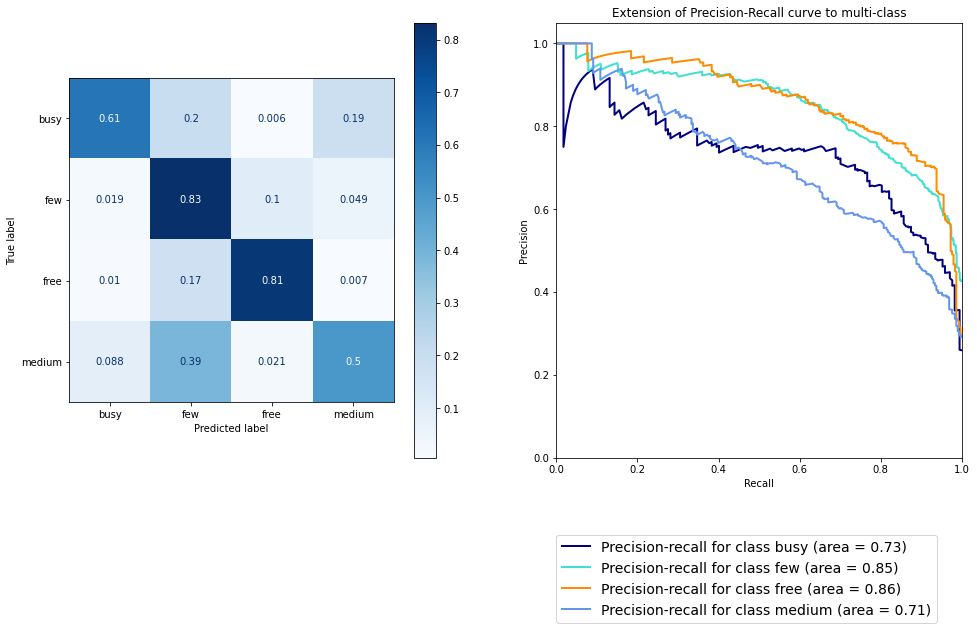

              precision    recall  f1-score   support

           0       0.73      0.61      0.66       167
           1       0.69      0.83      0.76       531
           2       0.79      0.81      0.80       287
           3       0.71      0.50      0.59       285

    accuracy                           0.72      1270
   macro avg       0.73      0.69      0.70      1270
weighted avg       0.72      0.72      0.72      1270

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 26.3min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 47.0min finished


{'n_estimators': 1810, 'min_samples_split': 2, 'max_features': 'sqrt', 'max_depth': 50}
accuracy: 0.7606299212598425
[[0.67065868 0.16766467 0.         0.16167665]
 [0.0094162  0.86440678 0.08851224 0.03766478]
 [0.00348432 0.15679443 0.83623693 0.00348432]
 [0.09122807 0.34736842 0.01754386 0.54385965]]


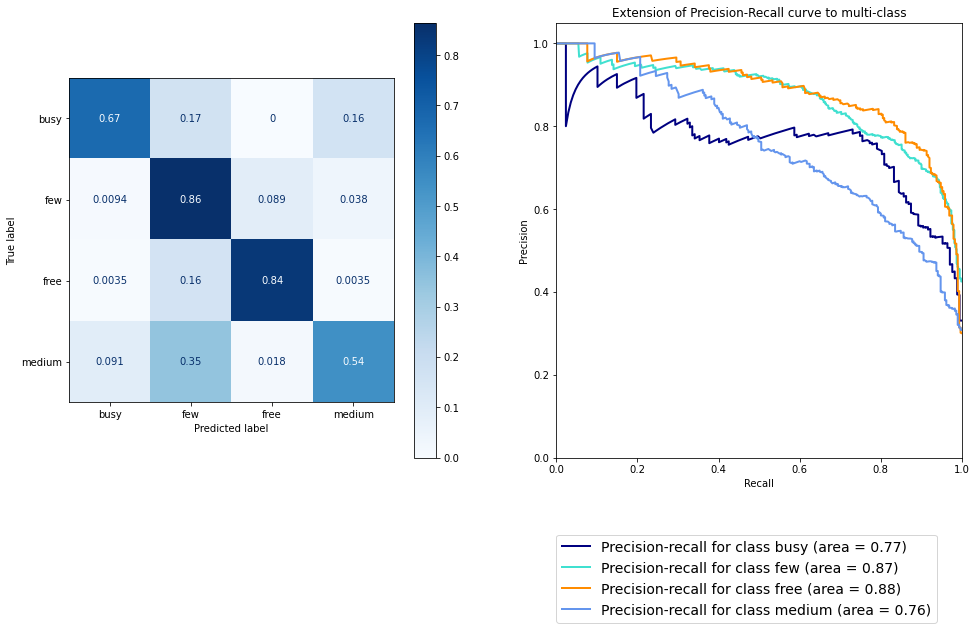

              precision    recall  f1-score   support

           0       0.78      0.67      0.72       167
           1       0.73      0.86      0.79       531
           2       0.82      0.84      0.83       287
           3       0.76      0.54      0.64       285

    accuracy                           0.76      1270
   macro avg       0.77      0.73      0.74      1270
weighted avg       0.76      0.76      0.75      1270



In [35]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

acc_range = {}
acc = {}

for num in numOfSamples:
    if num > 0:
        X_combine_train = np.concatenate((X_train[:num, :], dataP2), axis=0)
        y_combine_train = np.concatenate((y_train[:num],filtered_labels["total_encoder"]), axis=0)
    else:
        X_combine_train = dataP2
        y_combine_train = filtered_labels["total_encoder"]

    random_forest_clf = RandomForestClassifier(random_state=42)
    rf_random = RandomizedSearchCV(estimator = random_forest_clf, param_distributions = random_grid, n_iter = 20, cv = 3, verbose=2, random_state=42, n_jobs = -1)
    rf_random.fit(X_combine_train, y_combine_train)
    print(rf_random.best_params_)
    best_random = rf_random.best_estimator_
    random_accuracy = evaluate(best_random, X_test, y_test, labelencoder.classes_)
    acc[num] = random_accuracy
    acc_range[num] = rf_random.cv_results_

In [ ]:
print(acc_range)

In [36]:
print(acc)

{0: 0.28818897637795277, 100: 0.37086614173228344, 200: 0.41653543307086616, 500: 0.5149606299212598, 1000: 0.5598425196850394, 1500: 0.5803149606299213, 2000: 0.5952755905511811, 3000: 0.6086614173228346, 4000: 0.7236220472440945, 5076: 0.7606299212598425}


# concatenate audio with different amout of video

In [16]:
#split the audio data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(dataP2, filtered_labels["total_encoder"], test_size=0.2, random_state=42)

In [18]:
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import average_precision_score
from itertools import cycle
from sklearn.metrics import classification_report

training samples from video:  0
accuracy: 0.3543307086614173
[[0.         0.83832335 0.10778443 0.05389222]
 [0.03201507 0.79661017 0.11676083 0.05461394]
 [0.12195122 0.71080139 0.04878049 0.1184669 ]
 [0.04912281 0.8        0.10526316 0.04561404]]


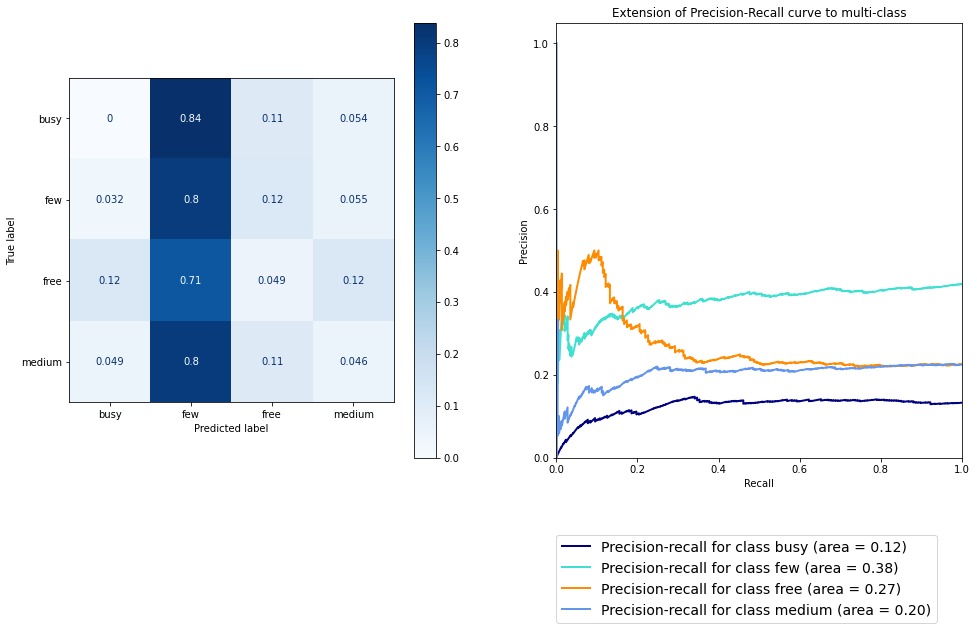

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       167
           1       0.43      0.80      0.55       531
           2       0.11      0.05      0.07       287
           3       0.15      0.05      0.07       285

    accuracy                           0.35      1270
   macro avg       0.17      0.22      0.17      1270
weighted avg       0.24      0.35      0.26      1270

training samples from video:  100
accuracy: 0.35039370078740156
[[0.02994012 0.80838323 0.10778443 0.05389222]
 [0.03766478 0.7834275  0.10922787 0.06967985]
 [0.09059233 0.75261324 0.03484321 0.12195122]
 [0.05263158 0.80701754 0.09122807 0.04912281]]


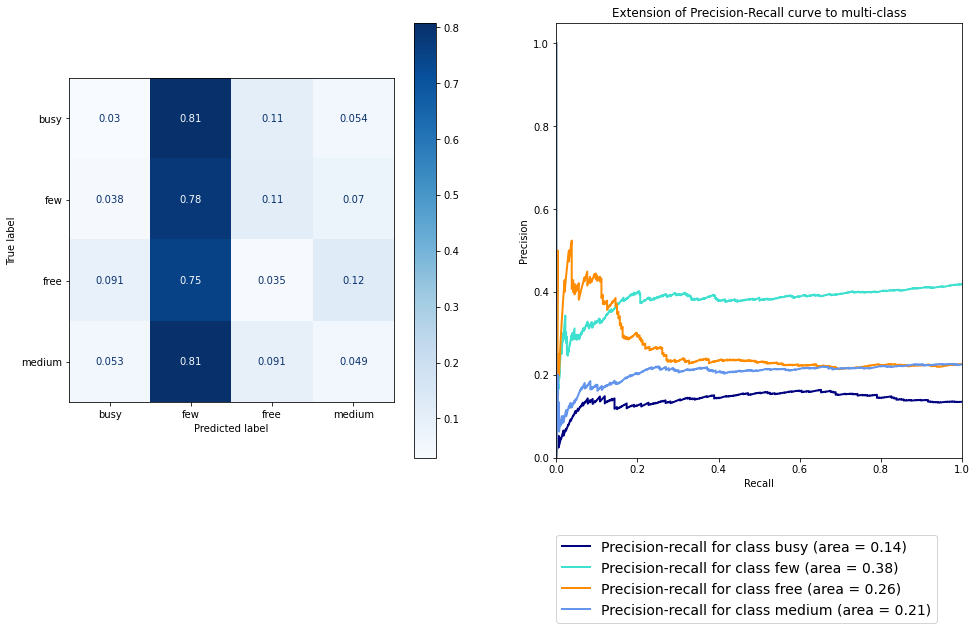

              precision    recall  f1-score   support

           0       0.08      0.03      0.04       167
           1       0.42      0.78      0.54       531
           2       0.09      0.03      0.05       287
           3       0.15      0.05      0.07       285

    accuracy                           0.35      1270
   macro avg       0.18      0.22      0.18      1270
weighted avg       0.24      0.35      0.26      1270

training samples from video:  200
accuracy: 0.3551181102362205
[[0.0239521  0.81437126 0.10778443 0.05389222]
 [0.03389831 0.79096045 0.11299435 0.06214689]
 [0.06968641 0.76655052 0.04181185 0.12195122]
 [0.05263158 0.78596491 0.10877193 0.05263158]]


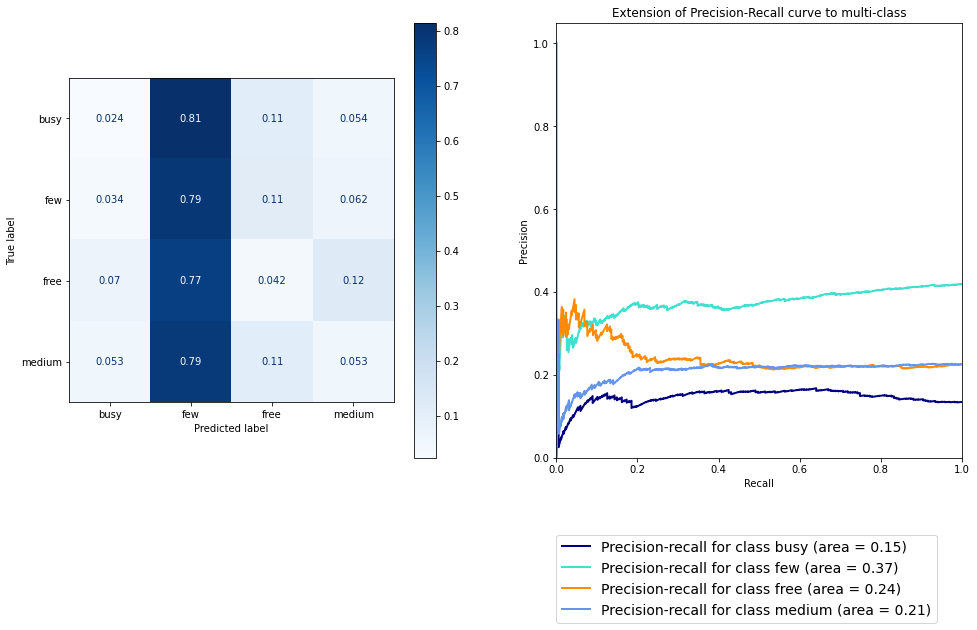

              precision    recall  f1-score   support

           0       0.07      0.02      0.04       167
           1       0.42      0.79      0.55       531
           2       0.10      0.04      0.06       287
           3       0.16      0.05      0.08       285

    accuracy                           0.36      1270
   macro avg       0.19      0.23      0.18      1270
weighted avg       0.24      0.36      0.27      1270

training samples from video:  500
accuracy: 0.36299212598425196
[[0.0239521  0.80239521 0.10179641 0.07185629]
 [0.03201507 0.79661017 0.10922787 0.06214689]
 [0.05574913 0.76655052 0.05574913 0.12195122]
 [0.03859649 0.78245614 0.11578947 0.06315789]]


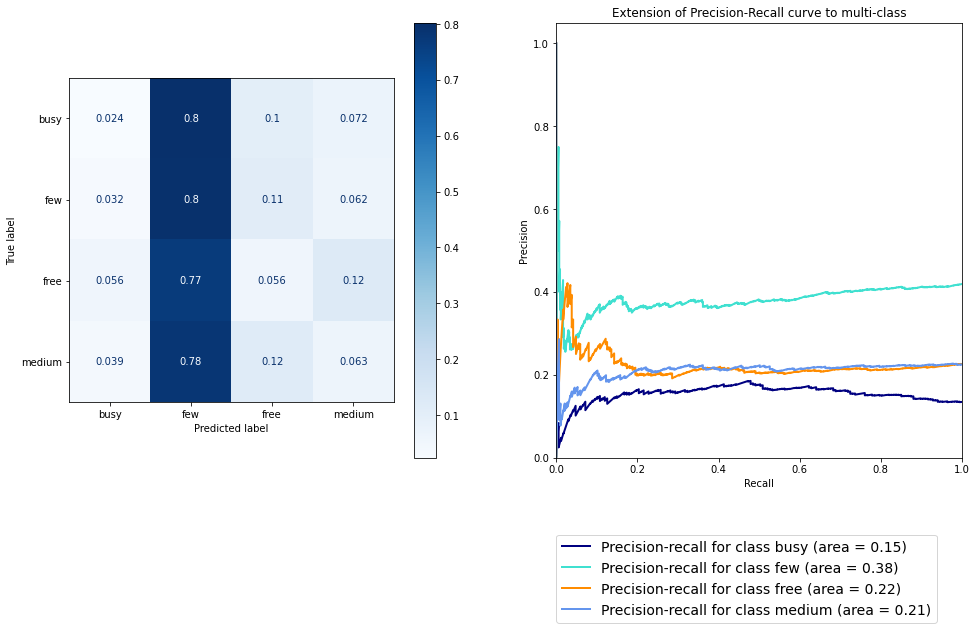

              precision    recall  f1-score   support

           0       0.08      0.02      0.04       167
           1       0.42      0.80      0.55       531
           2       0.13      0.06      0.08       287
           3       0.18      0.06      0.09       285

    accuracy                           0.36      1270
   macro avg       0.20      0.23      0.19      1270
weighted avg       0.26      0.36      0.27      1270

training samples from video:  1000
accuracy: 0.3653543307086614
[[0.0239521  0.84431138 0.07784431 0.05389222]
 [0.03013183 0.8079096  0.10357815 0.05838041]
 [0.04529617 0.79790941 0.05923345 0.09756098]
 [0.04210526 0.81754386 0.09122807 0.04912281]]


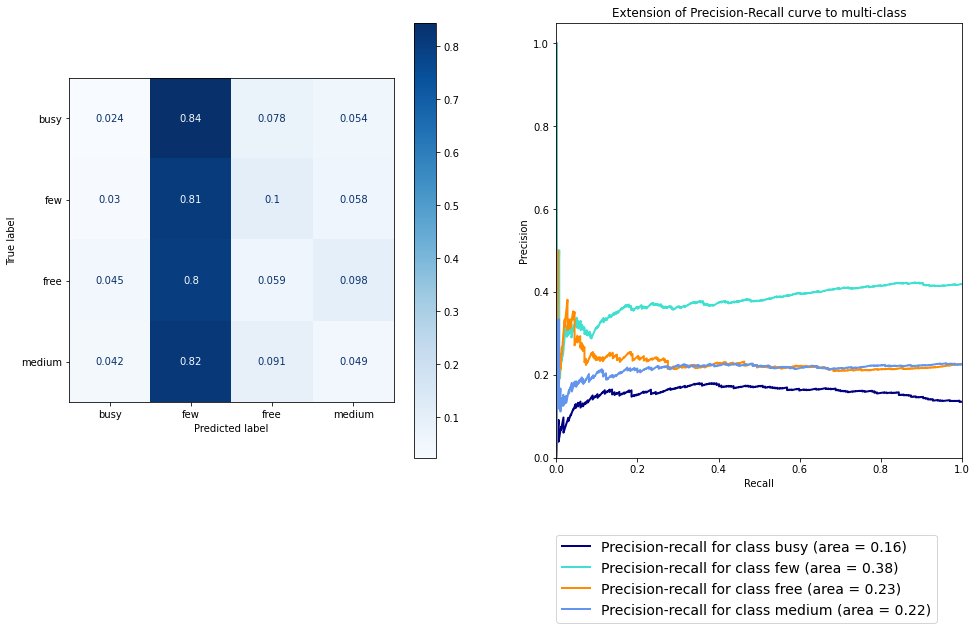

              precision    recall  f1-score   support

           0       0.09      0.02      0.04       167
           1       0.42      0.81      0.55       531
           2       0.15      0.06      0.09       287
           3       0.17      0.05      0.08       285

    accuracy                           0.37      1270
   macro avg       0.21      0.24      0.19      1270
weighted avg       0.26      0.37      0.27      1270

training samples from video:  1500
accuracy: 0.3826771653543307
[[0.0239521  0.8742515  0.06586826 0.03592814]
 [0.02824859 0.826742   0.09416196 0.05084746]
 [0.03135889 0.79790941 0.09756098 0.07317073]
 [0.0245614  0.8245614  0.09824561 0.05263158]]


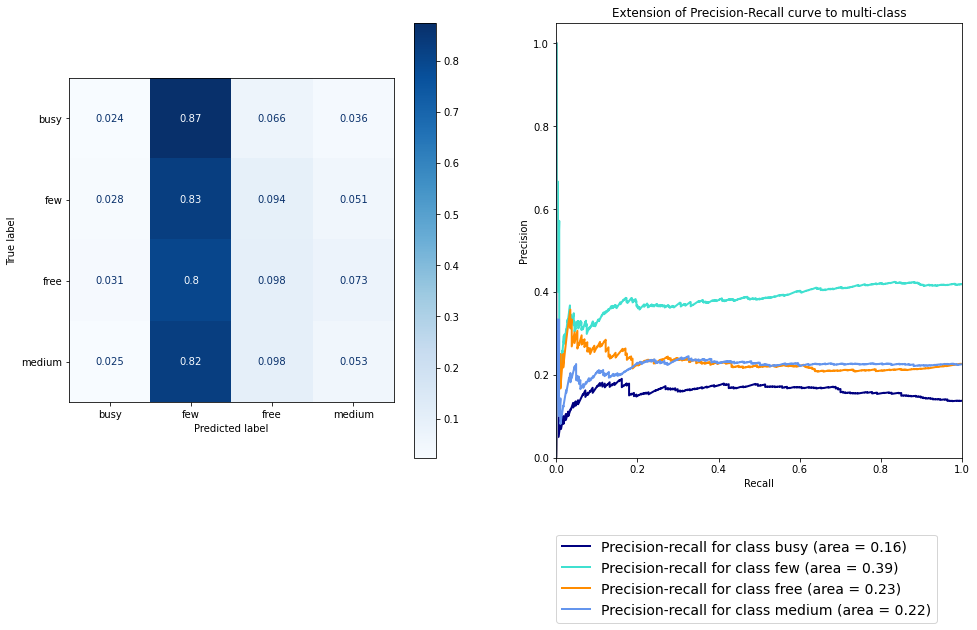

              precision    recall  f1-score   support

           0       0.11      0.02      0.04       167
           1       0.42      0.83      0.56       531
           2       0.24      0.10      0.14       287
           3       0.22      0.05      0.08       285

    accuracy                           0.38      1270
   macro avg       0.25      0.25      0.20      1270
weighted avg       0.29      0.38      0.29      1270

training samples from video:  2000
accuracy: 0.3937007874015748
[[0.04191617 0.86826347 0.06586826 0.0239521 ]
 [0.02259887 0.84180791 0.09227872 0.0433145 ]
 [0.0174216  0.78745645 0.12195122 0.07317073]
 [0.03157895 0.83859649 0.09122807 0.03859649]]


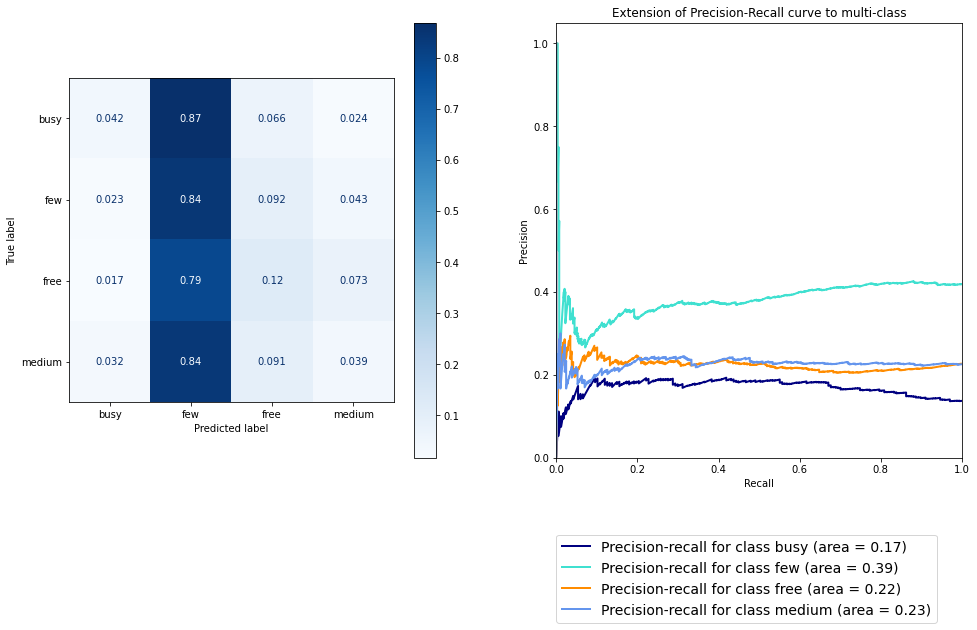

              precision    recall  f1-score   support

           0       0.21      0.04      0.07       167
           1       0.42      0.84      0.56       531
           2       0.29      0.12      0.17       287
           3       0.19      0.04      0.06       285

    accuracy                           0.39      1270
   macro avg       0.28      0.26      0.22      1270
weighted avg       0.31      0.39      0.30      1270

training samples from video:  3000
accuracy: 0.4062992125984252
[[0.02994012 0.88622754 0.05988024 0.0239521 ]
 [0.02824859 0.8700565  0.07344633 0.02824859]
 [0.03135889 0.81184669 0.12543554 0.03135889]
 [0.02807018 0.85614035 0.07017544 0.04561404]]


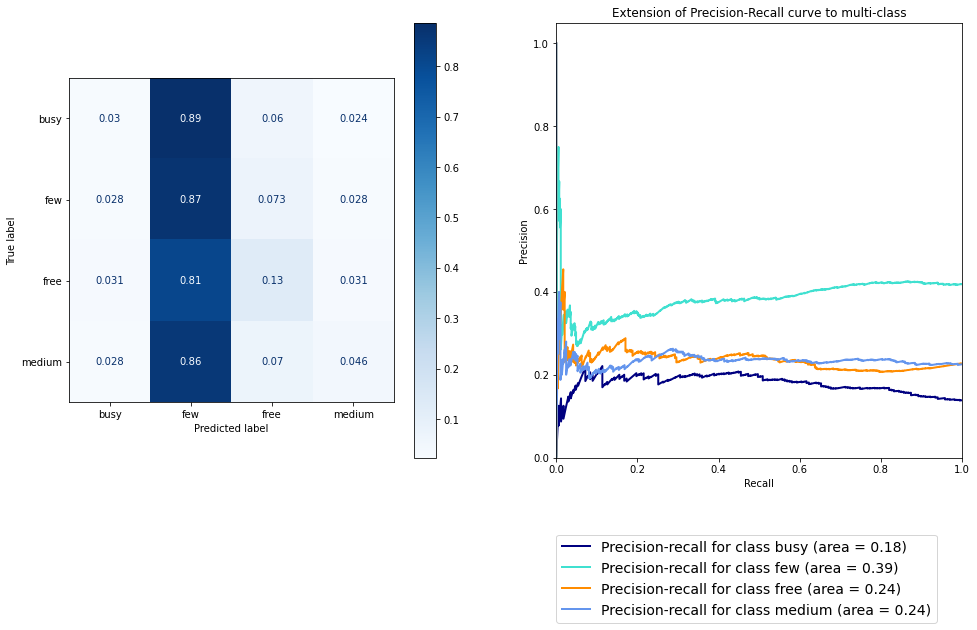

              precision    recall  f1-score   support

           0       0.14      0.03      0.05       167
           1       0.43      0.87      0.57       531
           2       0.34      0.13      0.18       287
           3       0.32      0.05      0.08       285

    accuracy                           0.41      1270
   macro avg       0.31      0.27      0.22      1270
weighted avg       0.34      0.41      0.30      1270

training samples from video:  4000
accuracy: 0.4149606299212598
[[0.02994012 0.89221557 0.05988024 0.01796407]
 [0.02824859 0.89642185 0.05649718 0.01883239]
 [0.02439024 0.81184669 0.12891986 0.03484321]
 [0.02105263 0.88070175 0.06666667 0.03157895]]


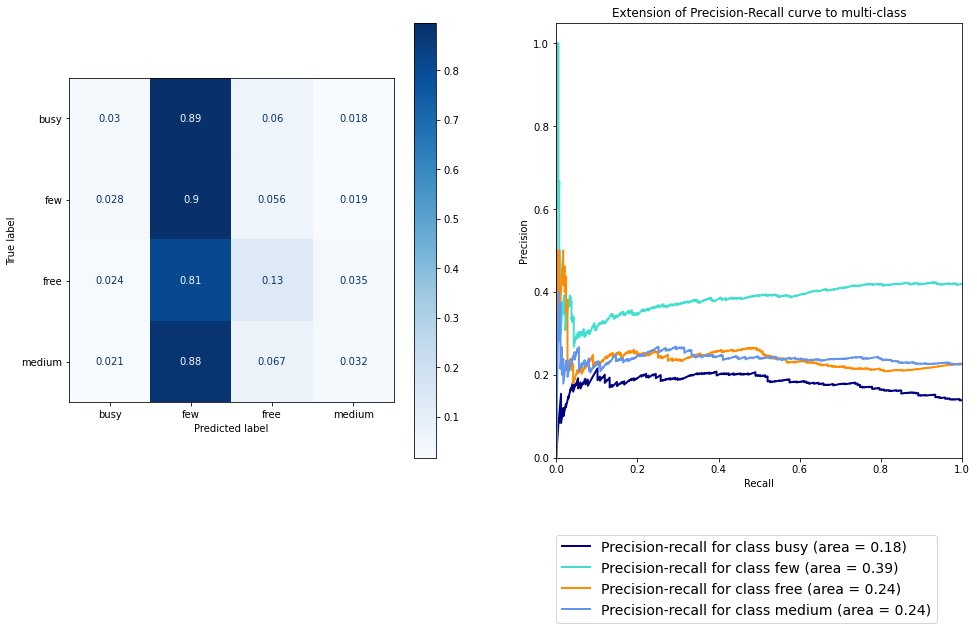

              precision    recall  f1-score   support

           0       0.15      0.03      0.05       167
           1       0.43      0.90      0.58       531
           2       0.39      0.13      0.19       287
           3       0.28      0.03      0.06       285

    accuracy                           0.41      1270
   macro avg       0.31      0.27      0.22      1270
weighted avg       0.35      0.41      0.31      1270

training samples from video:  5076
accuracy: 0.4149606299212598
[[0.01197605 0.93413174 0.04790419 0.00598802]
 [0.01883239 0.90207156 0.05649718 0.02259887]
 [0.02090592 0.81881533 0.13240418 0.02787456]
 [0.01754386 0.8877193  0.06666667 0.02807018]]


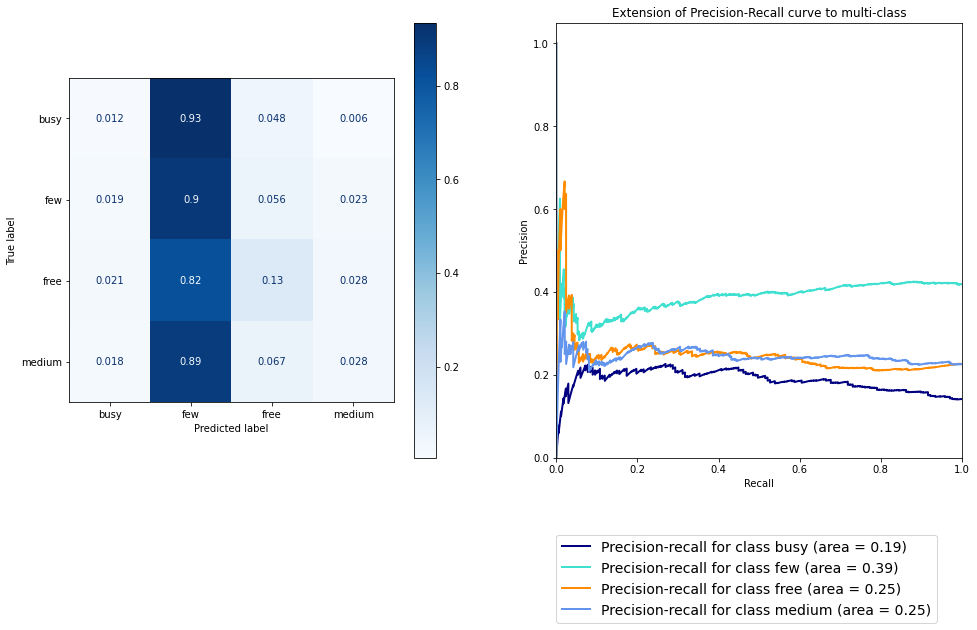

              precision    recall  f1-score   support

           0       0.09      0.01      0.02       167
           1       0.43      0.90      0.58       531
           2       0.40      0.13      0.20       287
           3       0.28      0.03      0.05       285

    accuracy                           0.41      1270
   macro avg       0.30      0.27      0.21      1270
weighted avg       0.34      0.41      0.30      1270



In [22]:
acc = {}
numOfSamples = [0, 100, 200, 500, 1000, 1500, 2000, 3000, 4000, 5076]

for num in numOfSamples:
    print("training samples from video: ", num)
    if num > 0:
        X_combine_train = np.concatenate((X_train[:num, :], dataP1), axis=0)
        y_combine_train = np.concatenate((y_train[:num],filtered_labels["total_encoder"]), axis=0)
    else:
        X_combine_train = dataP1
        y_combine_train = filtered_labels["total_encoder"]

    clf = SVC(kernel="linear", decision_function_shape="ovo", random_state=42)
    clf.fit(X_combine_train, y_combine_train)
    random_accuracy = evaluate_svm(clf, X_test, y_test, labelencoder.classes_)
    acc[num] = random_accuracy

training samples from audio:  0
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  6.7min finished


{'n_estimators': 200, 'min_samples_split': 2, 'max_features': 'sqrt', 'max_depth': 100}
accuracy: 0.41653543307086616
[[0.         1.         0.         0.        ]
 [0.         0.99435028 0.00188324 0.00376648]
 [0.         0.98954704 0.         0.01045296]
 [0.         0.99649123 0.         0.00350877]]


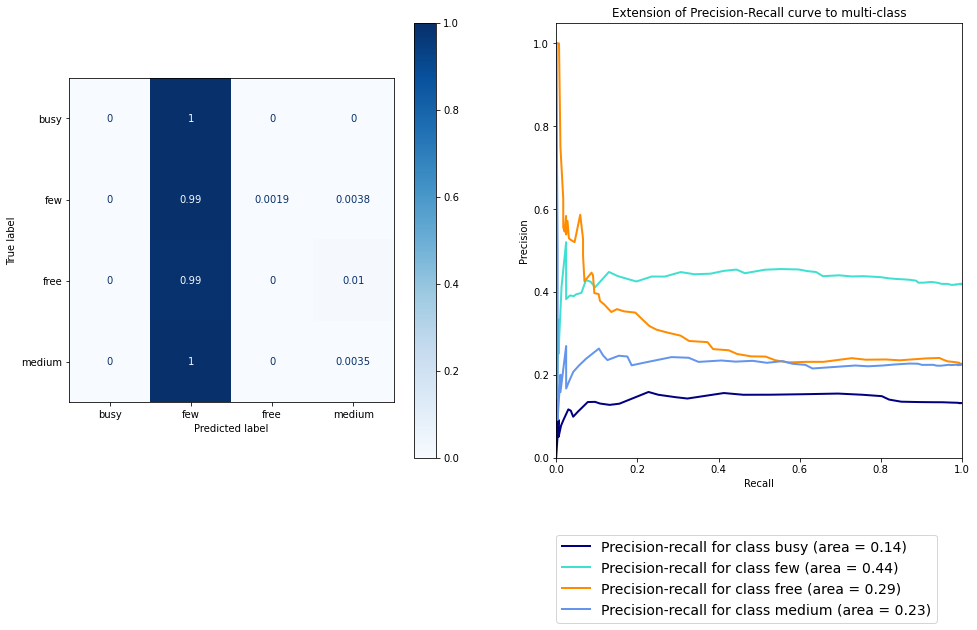

/Users/hou/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


              precision    recall  f1-score   support

           0       0.00      0.00      0.00       167
           1       0.42      0.99      0.59       531
           2       0.00      0.00      0.00       287
           3       0.17      0.00      0.01       285

    accuracy                           0.42      1270
   macro avg       0.15      0.25      0.15      1270
weighted avg       0.21      0.42      0.25      1270

training samples from audio:  100
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  6.5min finished


{'n_estimators': 294, 'min_samples_split': 5, 'max_features': 'sqrt', 'max_depth': 80}
accuracy: 0.41732283464566927
[[0.         0.96407186 0.         0.03592814]
 [0.         0.98681733 0.         0.01318267]
 [0.         0.99303136 0.         0.00696864]
 [0.         0.97894737 0.         0.02105263]]


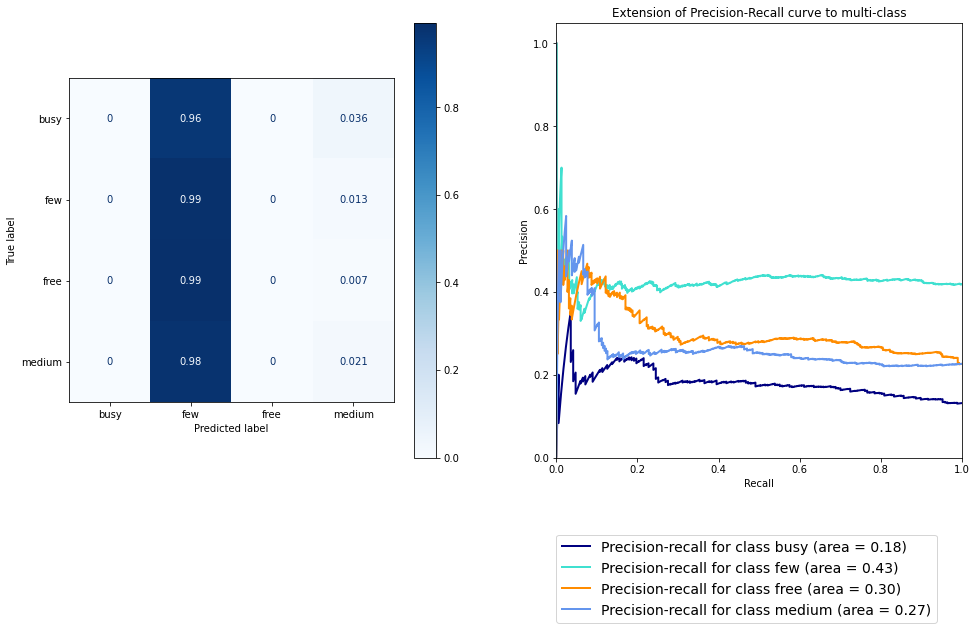

/Users/hou/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


              precision    recall  f1-score   support

           0       0.00      0.00      0.00       167
           1       0.42      0.99      0.59       531
           2       0.00      0.00      0.00       287
           3       0.29      0.02      0.04       285

    accuracy                           0.42      1270
   macro avg       0.18      0.25      0.16      1270
weighted avg       0.24      0.42      0.25      1270

training samples from audio:  200
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  6.8min finished


{'n_estimators': 294, 'min_samples_split': 5, 'max_features': 'sqrt', 'max_depth': 80}
accuracy: 0.4196850393700787
[[0.         0.95209581 0.00598802 0.04191617]
 [0.         0.97363465 0.00753296 0.01883239]
 [0.         0.97212544 0.01393728 0.01393728]
 [0.         0.95438596 0.00350877 0.04210526]]


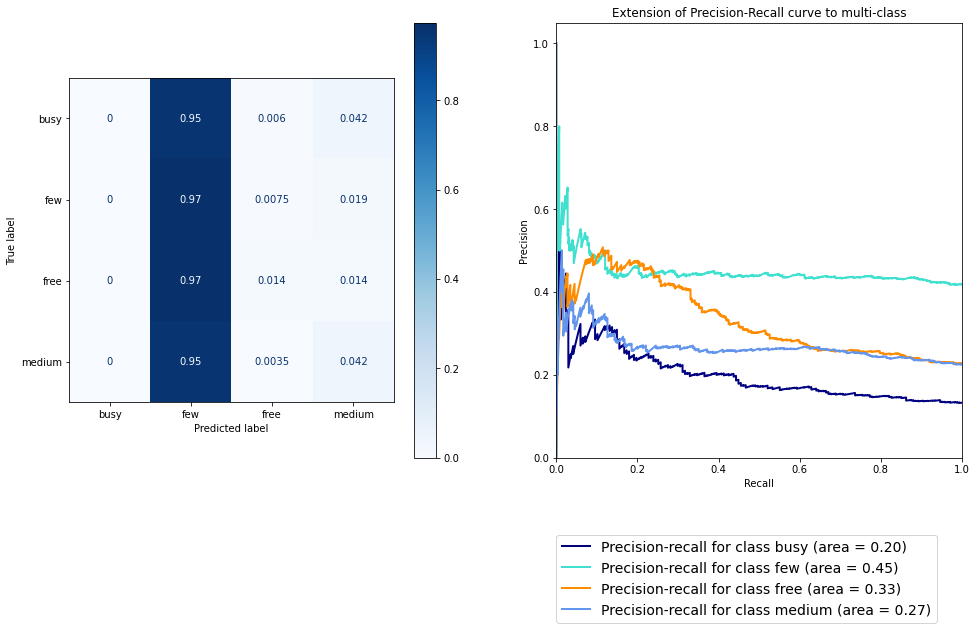

/Users/hou/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


              precision    recall  f1-score   support

           0       0.00      0.00      0.00       167
           1       0.42      0.97      0.59       531
           2       0.40      0.01      0.03       287
           3       0.36      0.04      0.08       285

    accuracy                           0.42      1270
   macro avg       0.30      0.26      0.17      1270
weighted avg       0.35      0.42      0.27      1270

training samples from audio:  500
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  7.1min finished


{'n_estimators': 200, 'min_samples_split': 2, 'max_features': 'sqrt', 'max_depth': 100}
accuracy: 0.41732283464566927
[[0.         0.94610778 0.01197605 0.04191617]
 [0.         0.94350282 0.02636535 0.03013183]
 [0.         0.92682927 0.05574913 0.0174216 ]
 [0.         0.94385965 0.01052632 0.04561404]]


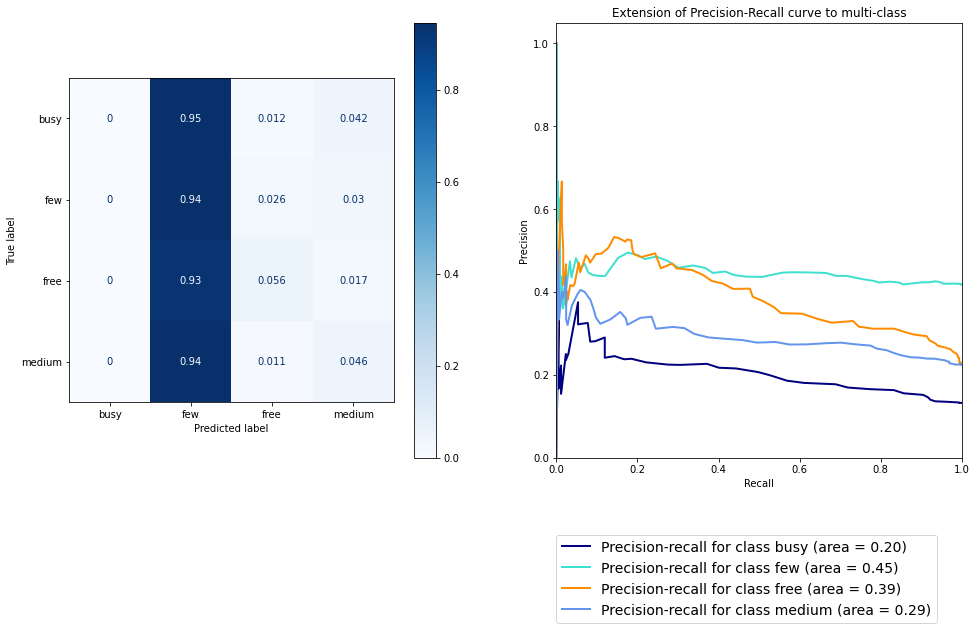

/Users/hou/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


              precision    recall  f1-score   support

           0       0.00      0.00      0.00       167
           1       0.42      0.94      0.58       531
           2       0.46      0.06      0.10       287
           3       0.32      0.05      0.08       285

    accuracy                           0.42      1270
   macro avg       0.30      0.26      0.19      1270
weighted avg       0.35      0.42      0.28      1270

training samples from audio:  1000
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  8.3min finished


{'n_estimators': 863, 'min_samples_split': 5, 'max_features': 'auto', 'max_depth': 90}
accuracy: 0.4283464566929134
[[0.0239521  0.94610778 0.01796407 0.01197605]
 [0.00564972 0.95291902 0.02824859 0.01318267]
 [0.         0.90592334 0.09059233 0.00348432]
 [0.         0.96842105 0.00350877 0.02807018]]


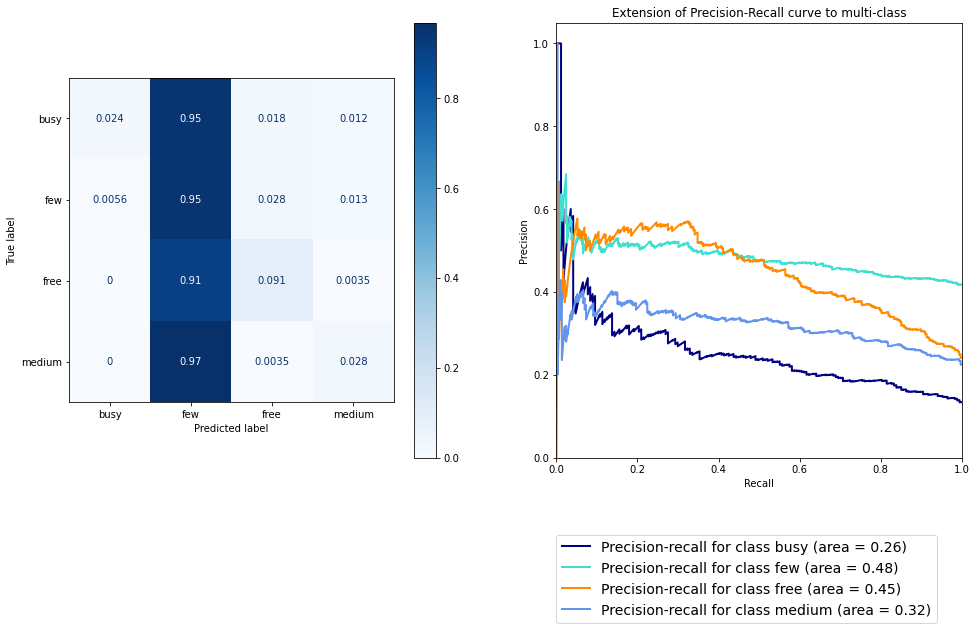

              precision    recall  f1-score   support

           0       0.57      0.02      0.05       167
           1       0.42      0.95      0.58       531
           2       0.58      0.09      0.16       287
           3       0.44      0.03      0.05       285

    accuracy                           0.43      1270
   macro avg       0.50      0.27      0.21      1270
weighted avg       0.48      0.43      0.30      1270

training samples from audio:  1500
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  8.7min finished


{'n_estimators': 484, 'min_samples_split': 5, 'max_features': 'sqrt', 'max_depth': 10}
accuracy: 0.4196850393700787
[[0.         1.         0.         0.        ]
 [0.         1.         0.         0.        ]
 [0.         0.99303136 0.00696864 0.        ]
 [0.         0.99649123 0.00350877 0.        ]]


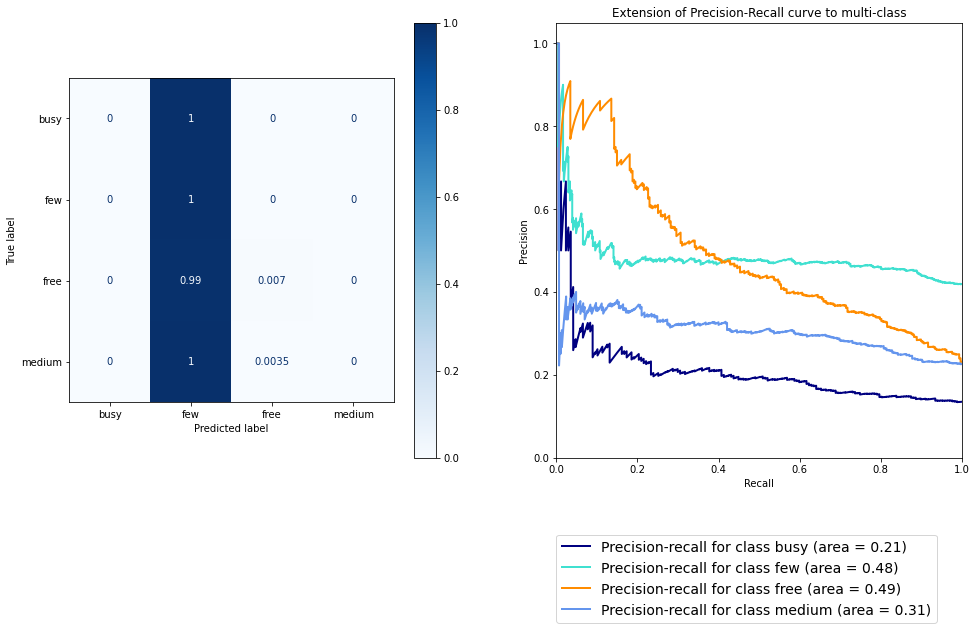

/Users/hou/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


              precision    recall  f1-score   support

           0       0.00      0.00      0.00       167
           1       0.42      1.00      0.59       531
           2       0.67      0.01      0.01       287
           3       0.00      0.00      0.00       285

    accuracy                           0.42      1270
   macro avg       0.27      0.25      0.15      1270
weighted avg       0.33      0.42      0.25      1270

training samples from audio:  2000
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  9.5min finished


{'n_estimators': 484, 'min_samples_split': 5, 'max_features': 'sqrt', 'max_depth': 10}
accuracy: 0.42283464566929135
[[0.         1.         0.         0.        ]
 [0.         1.         0.         0.        ]
 [0.         0.97909408 0.02090592 0.        ]
 [0.         1.         0.         0.        ]]


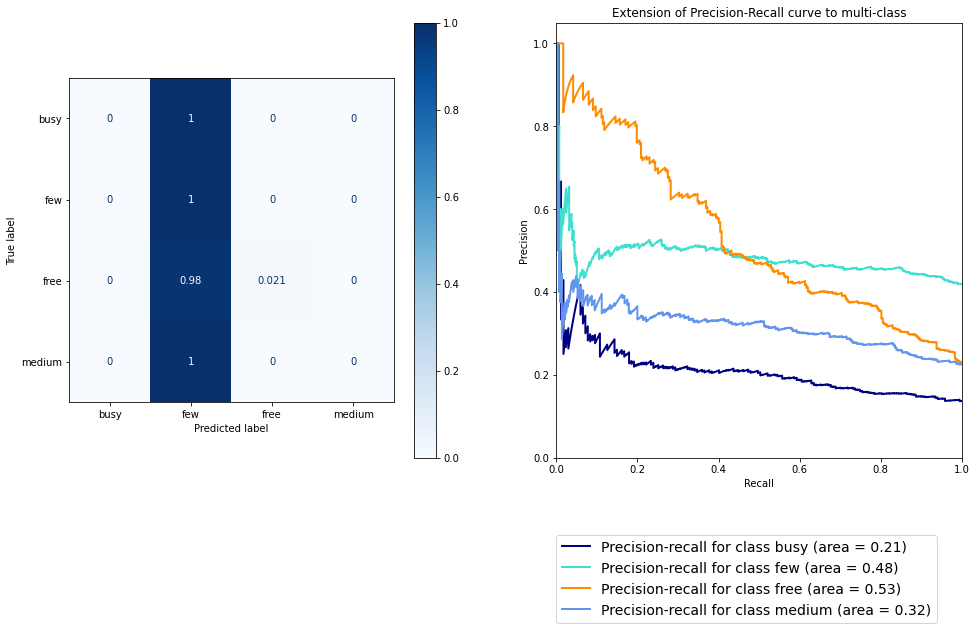

/Users/hou/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


              precision    recall  f1-score   support

           0       0.00      0.00      0.00       167
           1       0.42      1.00      0.59       531
           2       1.00      0.02      0.04       287
           3       0.00      0.00      0.00       285

    accuracy                           0.42      1270
   macro avg       0.36      0.26      0.16      1270
weighted avg       0.40      0.42      0.26      1270

training samples from audio:  3000
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 10.9min finished


{'n_estimators': 484, 'min_samples_split': 5, 'max_features': 'sqrt', 'max_depth': 10}
accuracy: 0.431496062992126
[[0.         1.         0.         0.        ]
 [0.         0.99811676 0.00188324 0.        ]
 [0.         0.93728223 0.06271777 0.        ]
 [0.         1.         0.         0.        ]]


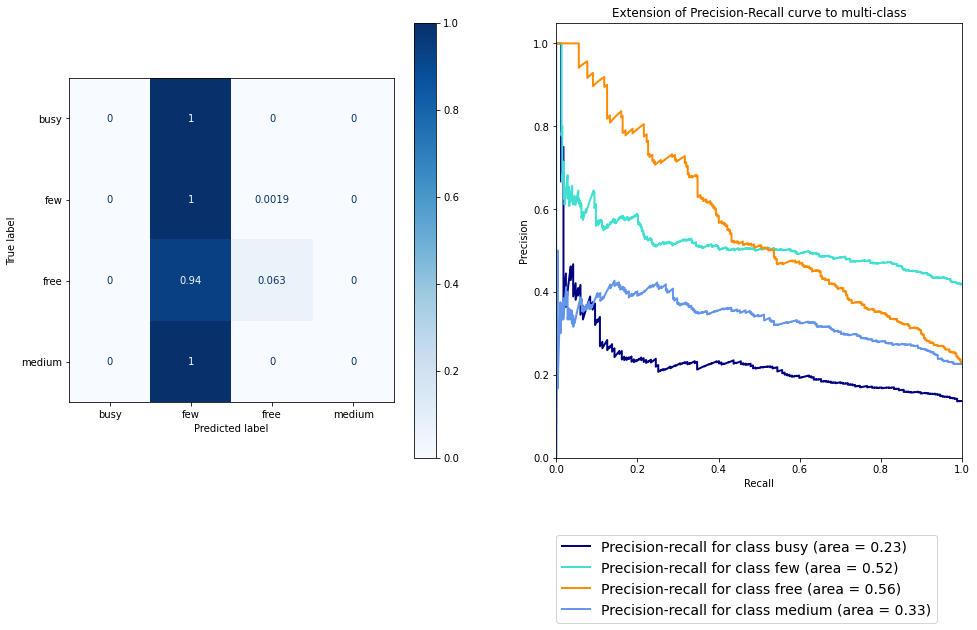

/Users/hou/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


              precision    recall  f1-score   support

           0       0.00      0.00      0.00       167
           1       0.42      1.00      0.59       531
           2       0.95      0.06      0.12       287
           3       0.00      0.00      0.00       285

    accuracy                           0.43      1270
   macro avg       0.34      0.27      0.18      1270
weighted avg       0.39      0.43      0.28      1270

training samples from audio:  4000
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 13.5min finished


{'n_estimators': 1431, 'min_samples_split': 2, 'max_features': 'sqrt', 'max_depth': 70}
accuracy: 0.4889763779527559
[[0.07185629 0.85628743 0.04790419 0.0239521 ]
 [0.00753296 0.91713748 0.06591337 0.0094162 ]
 [0.00696864 0.60627178 0.37630662 0.01045296]
 [0.01754386 0.90526316 0.02807018 0.04912281]]


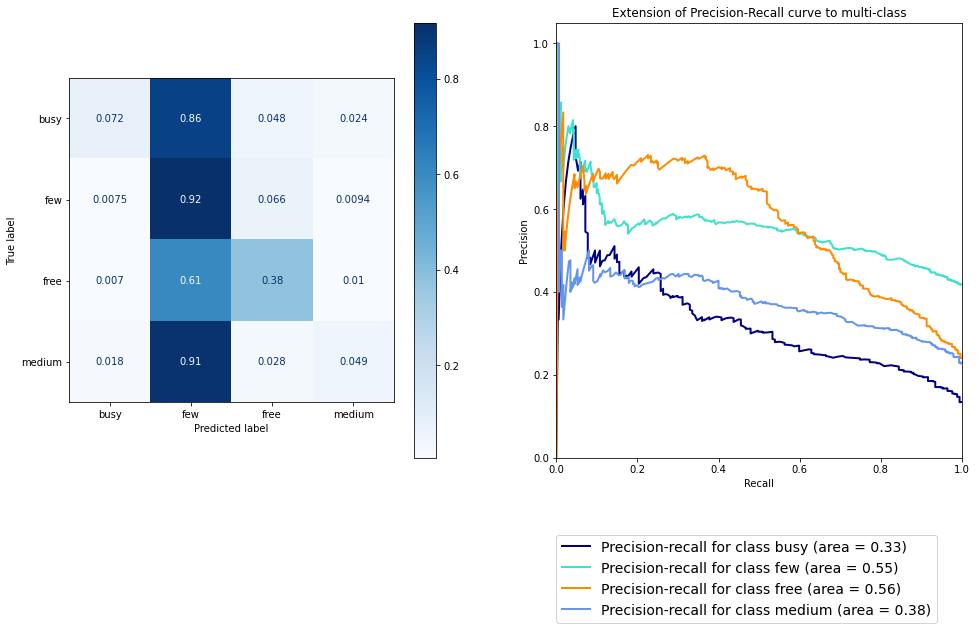

              precision    recall  f1-score   support

           0       0.52      0.07      0.13       167
           1       0.46      0.92      0.61       531
           2       0.68      0.38      0.48       287
           3       0.54      0.05      0.09       285

    accuracy                           0.49      1270
   macro avg       0.55      0.35      0.33      1270
weighted avg       0.53      0.49      0.40      1270

training samples from audio:  5076
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 15.1min finished


{'n_estimators': 768, 'min_samples_split': 5, 'max_features': 'auto', 'max_depth': 50}
accuracy: 0.49606299212598426
[[0.05988024 0.86227545 0.04790419 0.02994012]
 [0.00376648 0.92278719 0.06403013 0.0094162 ]
 [0.00696864 0.58885017 0.38327526 0.02090592]
 [0.01754386 0.88421053 0.02807018 0.07017544]]


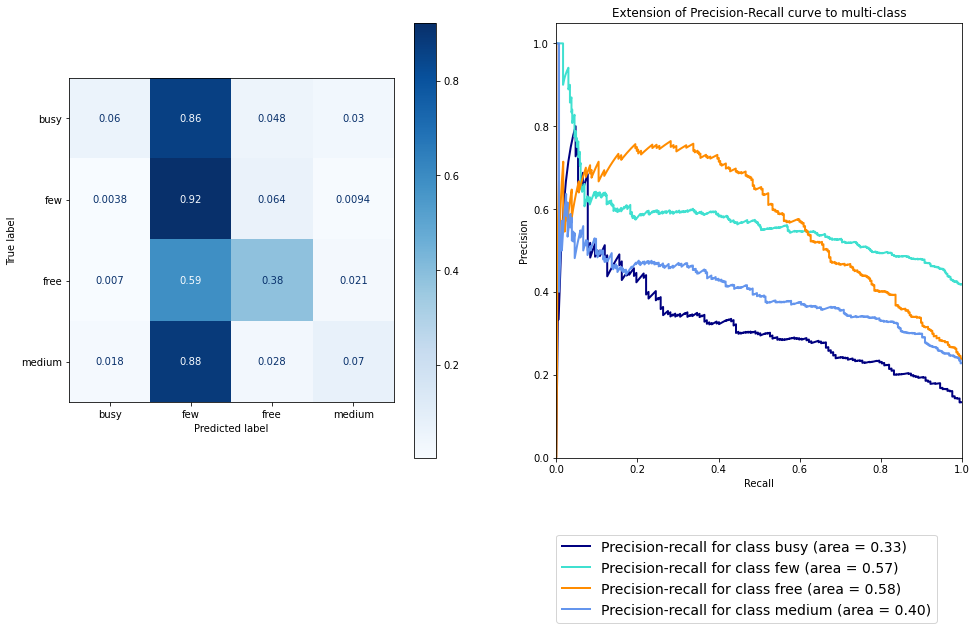

              precision    recall  f1-score   support

           0       0.53      0.06      0.11       167
           1       0.46      0.92      0.62       531
           2       0.69      0.38      0.49       287
           3       0.56      0.07      0.12       285

    accuracy                           0.50      1270
   macro avg       0.56      0.36      0.34      1270
weighted avg       0.54      0.50      0.41      1270



In [25]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

acc_range = {}
acc = {}

for num in numOfSamples:
    print("training samples from audio: ", num)

    if num > 0:
        X_combine_train = np.concatenate((X_train[:num, :], dataP1), axis=0)
        y_combine_train = np.concatenate((y_train[:num],filtered_labels["total_encoder"]), axis=0)
    else:
        X_combine_train = dataP1
        y_combine_train = filtered_labels["total_encoder"]

    random_forest_clf = RandomForestClassifier(random_state=42)
    rf_random = RandomizedSearchCV(estimator = random_forest_clf, param_distributions = random_grid, n_iter = 10, cv = 3, verbose=2, random_state=42, n_jobs = -1)
    rf_random.fit(X_combine_train, y_combine_train)
    print(rf_random.best_params_)
    best_random = rf_random.best_estimator_
    random_accuracy = evaluate(best_random, X_test, y_test, labelencoder.classes_)
    acc[num] = random_accuracy
    acc_range[num] = rf_random.cv_results_

In [26]:
print(acc)

{0: 0.41653543307086616, 100: 0.41732283464566927, 200: 0.4196850393700787, 500: 0.41732283464566927, 1000: 0.4283464566929134, 1500: 0.4196850393700787, 2000: 0.42283464566929135, 3000: 0.431496062992126, 4000: 0.4889763779527559, 5076: 0.49606299212598426}
